<a href="https://colab.research.google.com/github/Fanusaez/7506R-2C2022-GRUPO13/blob/sabado-1-10-2022/7506R_TP1_GRUPO13_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Trabajo Practico 1 : Propiedades en Venta

## Grupo 13

### Integrantes:

- Ivan Manuel Pensado
- Axel Tomas Higa
- Edgardo Francisco Saez
- Lautaro Barrionuevo
- Nicolás Carreño


# Importe de librerias


In [794]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import sklearn as sk
import scipy.stats as st

from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, MinMaxScaler

import geopandas
from shapely.geometry import Point
import osmnx as ox

# Lectura de archivo


In [795]:
ds_propiedades = pd.read_csv('properati_argentina_2021.csv')

In [796]:
ds_propiedades.head()

id  start_date    end_date  created_on    latitud  \
0  XZq2dFGxBiboHY3Bo/tqlw==  2021-09-09  2022-01-27  2021-09-09 -38.957632   
1  8afoK+yMH/rnnlYiktwgNA==  2021-09-09  2021-10-23  2021-09-09 -34.888878   
2  iVaG5rBB47dd1Ya4BMXREA==  2021-09-09  2022-03-09  2021-09-09 -32.488717   
3  QE1QVMWKAHWkd0qT0FtPWA==  2021-09-09  2022-01-27  2021-09-09 -34.900165   
4  tJ5lSk7IysG/71OGhacNZA==  2021-09-09  2022-01-27  2021-09-09 -38.954528   

    longitud    place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
0 -68.105443     Neuquén      NaN      NaN      NaN       NaN     Venta   
1 -56.092368  Montevideo      NaN      NaN      NaN       NaN     Venta   
2 -58.257499  Entre Ríos      NaN      NaN      NaN       NaN     Venta   
3 -54.808453   Maldonado      NaN      NaN      NaN       NaN     Venta   
4 -68.041862     Neuquén      NaN      NaN      NaN       NaN     Venta   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0          Casa             6.0                NaN                     NaN   
1          Casa             4.0                3.0                   193.0   
2          Casa             NaN                NaN                   110.0   
3          Casa             NaN                3.0                     NaN   
4            PH             3.0                2.0                     NaN   

   property_surface_covered  property_price property_currency  \
0                     206.0             NaN               NaN   
1                     193.0        390000.0               USD   
2                      45.0         47000.0               USD   
3                     180.0        400000.0               USD   
4                      98.0        102000.0               USD   

       property_title  
0      Casa - Capital  
1       Casa - Malvín  
2      Casa - Uruguay  
3    Casa - El Chorro  
4  PH - Villa Farrell

# Análisis Exploratorio y Preprocesamiento de Dato


Se deben filtrar únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).

In [797]:
ds_prop_filtrado = ds_propiedades[ds_propiedades.place_l2.str.contains('Capital Federal', case=False, na = False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.property_type.str.fullmatch('Departamento|Casa|ph', case = False, na = False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.operation.str.contains('venta', case=False, na =  False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.property_currency.str.contains('USD', case=False, na =  False)] 

Division Train/Test

In [798]:
train, test = train_test_split(ds_prop_filtrado,
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=0)
print('# Datos Entrenamiento: {}'.format(len(train)))
print('# Datos Prueba: {}'.format(len(test)))

# Datos Entrenamiento: 75399
# Datos Prueba: 18850


## Exploración inicial


Tipo de variable


In [799]:
ds_train = train 
ds_test = test

In [800]:
ds_train.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Variables Cuantitativas


In [801]:
cuantitativos = ["latitud", "longitud", "property_rooms", "property_bedrooms","property_surface_total", "property_surface_covered", "property_price"]
ds_cuantitativo = ds_train.loc[:,cuantitativos]
ds_resumen_cuantitativo = pd.DataFrame()
ds_resumen_cuantitativo["media"] = ds_cuantitativo.mean()
ds_resumen_cuantitativo["mediana"] = ds_cuantitativo.median()
ds_resumen_cuantitativo["q1"] = ds_cuantitativo.quantile([.25]).iloc[0]
ds_resumen_cuantitativo["q3"] = ds_cuantitativo.quantile([.75]).iloc[0]
ds_resumen_cuantitativo["moda"] = ds_cuantitativo.mode().iloc[0]
ds_resumen_cuantitativo

media        mediana            q1  \
latitud                      -34.591533     -34.595789    -34.615975   
longitud                     -58.449751     -58.438956    -58.466432   
property_rooms                 2.824120       3.000000      2.000000   
property_bedrooms              2.015962       2.000000      1.000000   
property_surface_total       112.591274      65.000000     45.000000   
property_surface_covered      88.870856      58.000000     40.000000   
property_price            227201.214446  144000.000000  95000.000000   

                                     q3           moda  
latitud                      -34.577400     -34.541250  
longitud                     -58.408862     -58.472966  
property_rooms                 4.000000       3.000000  
property_bedrooms              3.000000       1.000000  
property_surface_total       105.000000      50.000000  
property_surface_covered      88.000000      40.000000  
property_price            236000.000000  110000.000000

Variables Cualitativas


In [802]:
cualitativos = ["place_l2", "place_l3", "operation", "property_type", "property_currency", "property_title"]
ds_cualitativo = ds_train.loc[:,cualitativos]

- Mostrar cantidad de valores posibles


In [803]:
ds_cualitativo.nunique()

place_l2                 1
place_l3                57
operation                1
property_type            3
property_currency        1
property_title       46431
dtype: int64

- Mostrar frecuencias
  - Obviamos las opciones de un solo tipo porque la frecuencia es de 100%


In [804]:
ds_cualitativo.place_l3.value_counts(normalize=True)* 100

Palermo                 15.351315
Belgrano                 9.561106
Caballito                7.640360
Recoleta                 6.693307
Villa Urquiza            4.981685
Almagro                  4.354312
Nuñez                    3.741592
Villa Crespo             3.381951
Flores                   3.266067
Barrio Norte             3.132867
Balvanera                2.683983
Colegiales               2.075258
Villa Devoto             2.049950
Villa del Parque         1.970030
Saavedra                 1.911422
Puerto Madero            1.607726
San Telmo                1.459873
San Cristobal            1.405261
San Nicolás              1.377289
Barracas                 1.345321
Retiro                   1.313353
Boedo                    1.306693
Floresta                 1.268065
Monserrat                1.200133
Parque Chacabuco         1.165501
Villa Pueyrredón         1.082917
Coghlan                  1.040293
Villa Luro               0.771229
Mataderos                0.764569
Chacarita     

In [805]:
ds_cualitativo.property_type.value_counts(normalize=True)* 100

Departamento    85.792915
PH               9.868831
Casa             4.338254
Name: property_type, dtype: float64

In [806]:
ds_cualitativo.property_title.value_counts(normalize=True)* 100

Departamento - Palermo                                                                                               1.588880
Departamento - Recoleta                                                                                              1.388613
Departamento - Belgrano                                                                                              1.141925
Departamento - Caballito                                                                                             0.998687
Departamento - Almagro                                                                                               0.710885
                                                                                                                       ...   
Departamento - Villa Crespo- Palermo Crespo- New-                                                                    0.001326
Excelente depto. Carlos Pellegrini y Posadas, contrafrente con espectacular vistas a jardines y rio; todo externo    0

- Determinar variables irrelevantes en el análisis


Debido a que las caracteristicas cualitativas "place_l2", "operation", "Property_currency" solo poseen un valor posible, es irrelevante para el analisis de datos. 

La caracteristica de "Property_title" al ser una descripcion del vendedor no aporta mucha informacion analitica. 

Los datos que no aportan al analisis, son las fechas, de las columnas "Start_date", "End_date" y "Created_on" debido a que no se especifica que significa dichas fechas e "ID"




In [807]:
columnas_irrelevantes = ["id", "start_date","end_date", "created_on","place_l2" , "operation", "property_currency", "property_title"]

def eliminar_columnas_irrelevantes(dataset):
    dataset.drop(columns = columnas_irrelevantes, inplace = True)

eliminar_columnas_irrelevantes(ds_train)
eliminar_columnas_irrelevantes(ds_test)
ds_train.head()

latitud   longitud  place_l3 place_l4 place_l5  place_l6  \
280087 -34.601807 -58.469965  Paternal      NaN      NaN       NaN   
256350 -34.580088 -58.424965   Palermo      NaN      NaN       NaN   
135168 -34.551481 -58.452358  Belgrano      NaN      NaN       NaN   
227831 -34.632290 -58.464844    Flores      NaN      NaN       NaN   
409101 -34.549279 -58.463074     Nuñez      NaN      NaN       NaN   

       property_type  property_rooms  property_bedrooms  \
280087  Departamento             2.0                1.0   
256350  Departamento             2.0                1.0   
135168  Departamento             1.0                1.0   
227831  Departamento             5.0                3.0   
409101  Departamento             2.0                1.0   

        property_surface_total  property_surface_covered  property_price  
280087                    53.0                      49.0         80000.0  
256350                    35.0                      35.0         79900.0  
135168                    25.0                      20.0         69000.0  
227831                    75.0                      75.0        150000.0  
409101                    46.0                      34.0         85000.0

Duplicados


In [808]:
ds_train.duplicated

<bound method DataFrame.duplicated of           latitud   longitud       place_l3 place_l4 place_l5  place_l6  \
280087 -34.601807 -58.469965       Paternal      NaN      NaN       NaN   
256350 -34.580088 -58.424965        Palermo      NaN      NaN       NaN   
135168 -34.551481 -58.452358       Belgrano      NaN      NaN       NaN   
227831 -34.632290 -58.464844         Flores      NaN      NaN       NaN   
409101 -34.549279 -58.463074          Nuñez      NaN      NaN       NaN   
...           ...        ...            ...      ...      ...       ...   
102622 -34.628714 -58.413872          Boedo      NaN      NaN       NaN   
224388 -34.587318 -58.452157      Chacarita      NaN      NaN       NaN   
206610 -34.597385 -58.426269   Villa Crespo      NaN      NaN       NaN   
212425 -34.601109 -58.425161        Almagro      NaN      NaN       NaN   
335036 -34.577672 -58.495749  Villa Urquiza      NaN      NaN       NaN   

       property_type  property_rooms  property_bedrooms  \
28

### Análisis gráfico de las distribuciones de las variables


#### Barrio

Cantidad de barrios

In [809]:
cant_barrios = ds_train["place_l3"].unique().size
print("La cantidad de Barrios es: " + str(cant_barrios))

La cantidad de Barrios es: 58


Cantidadad de propiedades por barrios

In [810]:
ds_train["place_l3"].value_counts()

Palermo                 11525
Belgrano                 7178
Caballito                5736
Recoleta                 5025
Villa Urquiza            3740
Almagro                  3269
Nuñez                    2809
Villa Crespo             2539
Flores                   2452
Barrio Norte             2352
Balvanera                2015
Colegiales               1558
Villa Devoto             1539
Villa del Parque         1479
Saavedra                 1435
Puerto Madero            1207
San Telmo                1096
San Cristobal            1055
San Nicolás              1034
Barracas                 1010
Retiro                    986
Boedo                     981
Floresta                  952
Monserrat                 901
Parque Chacabuco          875
Villa Pueyrredón          813
Coghlan                   781
Villa Luro                579
Mataderos                 574
Chacarita                 555
Liniers                   534
Villa Ortuzar             529
Parque Patricios          514
Villa Luga

Distribucion

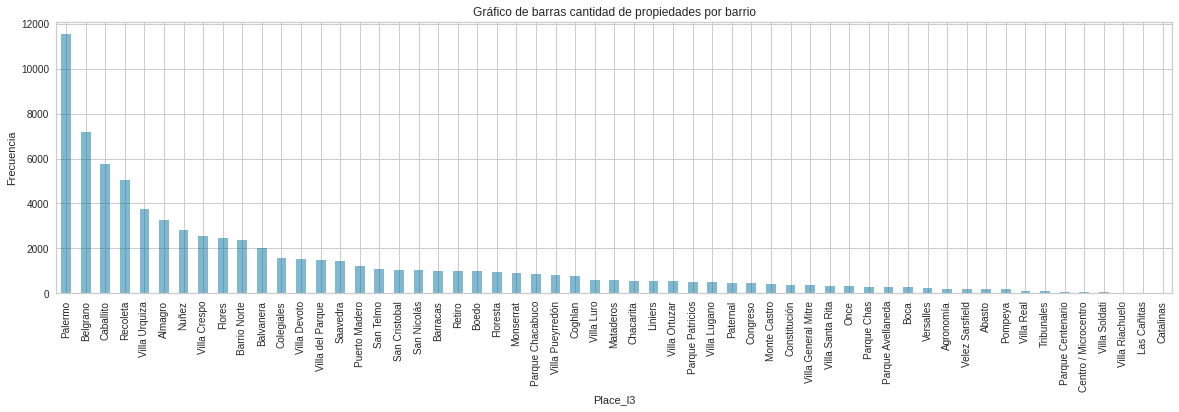

In [811]:
grf_ds=ds_train["place_l3"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de propiedades por barrio" , xlabel="Place_l3" , ylabel="Frecuencia", figsize=(20,5))

Precio promedio de propiedad por barrio

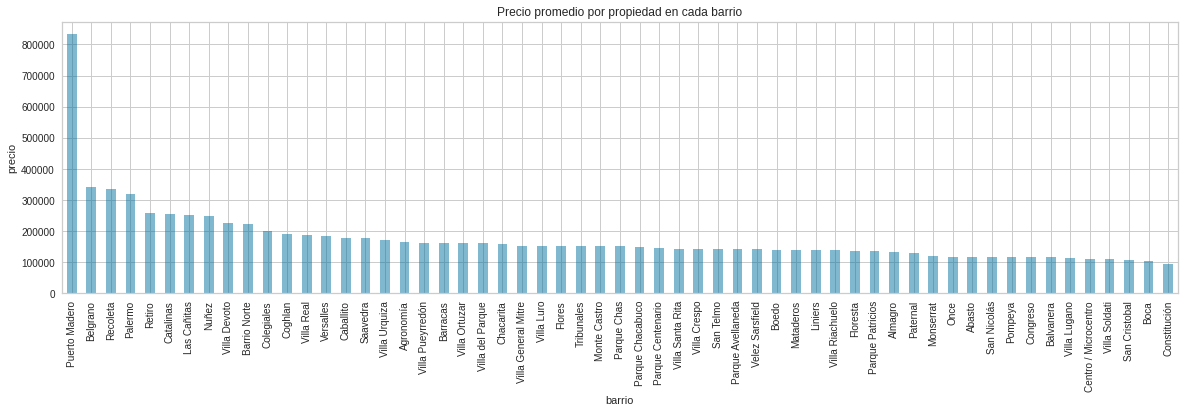

In [812]:
ds_precio_prom = ds_train.groupby(["place_l3"])["property_price"].mean().sort_values(ascending=False)
grf_ds=ds_precio_prom.plot.bar(alpha=0.5 , title="Precio promedio por propiedad en cada barrio" , xlabel="barrio" , ylabel="precio", figsize=(20,5))

#### Rooms

Cantidad de propiedades con 'n' habitaciones

In [813]:
ds_train["property_rooms"].value_counts()

3.0     21470
2.0     21120
4.0     13128
1.0     12053
5.0      4135
6.0      1464
7.0       596
8.0       283
9.0       136
10.0       83
11.0       26
12.0       25
14.0       15
15.0       10
13.0        6
16.0        3
20.0        3
18.0        2
17.0        2
19.0        2
30.0        1
35.0        1
24.0        1
28.0        1
32.0        1
36.0        1
Name: property_rooms, dtype: int64

Box plot

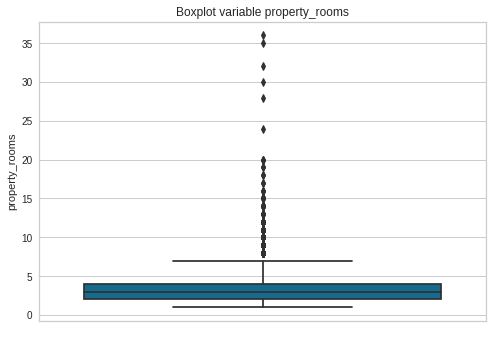

In [814]:
grf=sns.boxplot(y="property_rooms", data=ds_train).set(title="Boxplot variable property_rooms",xlabel=" ",ylabel="property_rooms")

#### Bedrooms

Cantidad de propiedades con 'n' dormitorios

In [815]:
ds_train["property_bedrooms"].value_counts()

 1.0     25513
 2.0     22047
 3.0     14112
 4.0      3821
 5.0       742
 6.0       194
 7.0        84
 8.0        48
 10.0       22
 9.0        21
 12.0       15
 16.0        6
 11.0        6
 14.0        5
 32.0        3
 13.0        3
 18.0        3
 20.0        3
 17.0        3
 15.0        3
 22.0        2
 70.0        1
 30.0        1
-1.0         1
Name: property_bedrooms, dtype: int64

Boxplot

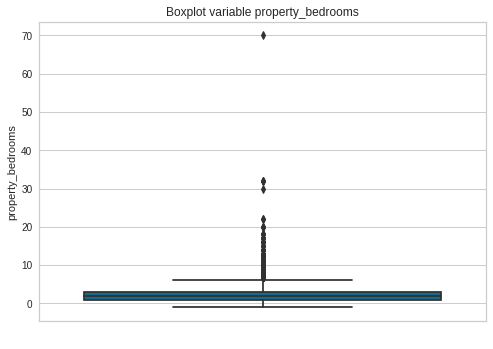

In [816]:
grf=sns.boxplot(y="property_bedrooms", data=ds_train).set(title="Boxplot variable property_bedrooms",xlabel=" ",ylabel="property_bedrooms")

#### Surface Total & Covered

Boxplot surface_total

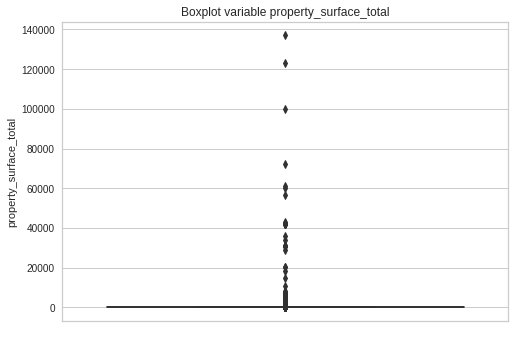

In [817]:
grf=sns.boxplot(y="property_surface_total", data=ds_train).set(title="Boxplot variable property_surface_total",xlabel=" ",ylabel="property_surface_total")

Boxplot suface_covered

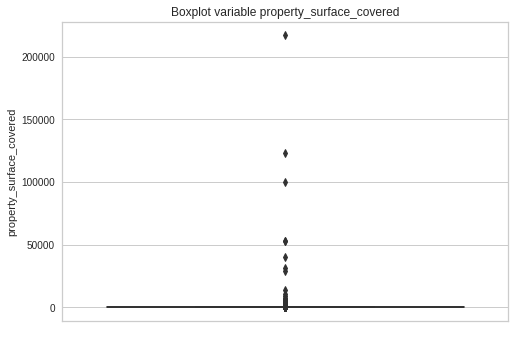

In [818]:
grf=sns.boxplot(y="property_surface_covered", data=ds_train).set(title="Boxplot variable property_surface_covered",xlabel=" ",ylabel="property_surface_covered")

Valor maximo, minimo y promedio

In [819]:
max = ds_train["property_surface_total"].max()
min = ds_train["property_surface_total"].min()
mean = ds_train["property_surface_total"].mean().round()

print("Property_surface_total")
print("El valor maximo es: " + str(max))
print("El valor minimo es: " + str(min))
print("El valor promedio es: " + str(mean) + "\n")

max = ds_train["property_surface_covered"].max()
min = ds_train["property_surface_covered"].min()
mean = ds_train["property_surface_covered"].mean().round()

print("Property_surface_covered")
print("El valor maximo es: " + str(max))
print("El valor minimo es: " + str(min))
print("El valor promedio es: " + str(mean))



Property_surface_total
El valor maximo es: 137000.0
El valor minimo es: 10.0
El valor promedio es: 113.0

Property_surface_covered
El valor maximo es: 217000.0
El valor minimo es: 1.0
El valor promedio es: 89.0


#### Price

Boxplot

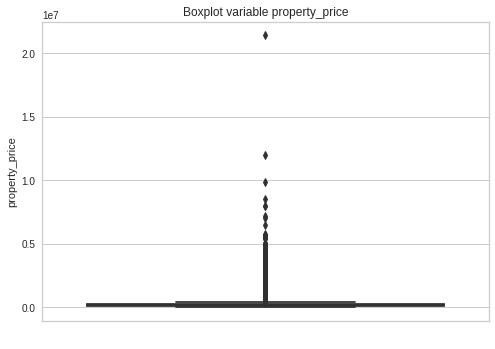

In [820]:
grf=sns.boxplot(y="property_price", data=ds_train).set(title="Boxplot variable property_price",xlabel=" ",ylabel="property_price")

Precio maximo y minimo y promedio

In [821]:
max = ds_train["property_price"].max()
min = ds_train["property_price"].min()
mean = ds_train["property_price"].mean().round()

print("El precio maximo es: " + str(max))
print("El precio minimo es: " + str(min))
print("El precio promedio es: " + str(mean))


El precio maximo es: 21400000.0
El precio minimo es: 5000.0
El precio promedio es: 227201.0


### Correlaciones existentes entre las variables


- Analizar las correlaciones existentes entre las variables.


In [822]:
ds_train.corr()

latitud  longitud  place_l6  property_rooms  \
latitud                   1.000000 -0.230156       NaN        0.003493   
longitud                 -0.230156  1.000000       NaN       -0.007947   
place_l6                       NaN       NaN       NaN             NaN   
property_rooms            0.003493 -0.007947       NaN        1.000000   
property_bedrooms         0.000608 -0.008389       NaN        0.871541   
property_surface_total    0.024694 -0.014160       NaN        0.061457   
property_surface_covered  0.001964 -0.000942       NaN        0.074062   
property_price            0.016166  0.023086       NaN        0.483192   

                          property_bedrooms  property_surface_total  \
latitud                            0.000608                0.024694   
longitud                          -0.008389               -0.014160   
place_l6                                NaN                     NaN   
property_rooms                     0.871541                0.061457   
property_bedrooms                  1.000000                0.062421   
property_surface_total             0.062421                1.000000   
property_surface_covered           0.067214                0.660050   
property_price                     0.416916                0.081746   

                          property_surface_covered  property_price  
latitud                                   0.001964        0.016166  
longitud                                 -0.000942        0.023086  
place_l6                                       NaN             NaN  
property_rooms                            0.074062        0.483192  
property_bedrooms                         0.067214        0.416916  
property_surface_total                    0.660050        0.081746  
property_surface_covered                  1.000000        0.053285  
property_price                            0.053285        1.000000

- Notar alta correlacion entre "property_rooms" y "property_bedrooms", lo cual tiene mucho sentido ya que un departamento de 3 ambientes tiene 2 habitaciones, uno de 4 ambientes tiene 3 habitacioenes etc 
- Tambien podemos encontrar una correlcion moderada entre "property_surface_total" y "property_surface_covered" lo cual tambien se asemeja a la relaidad. Lo mismo con "property_price" y "property_rooms"

#### Propety_bedrooms y Property_rooms

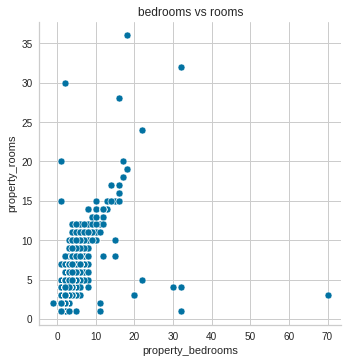

In [823]:
graf_relplot=sns.relplot(data=ds_train, x="property_bedrooms", y="property_rooms").set(title="bedrooms vs rooms",xlabel='property_bedrooms',ylabel='property_rooms')

#### Surface_total y Surface_covered

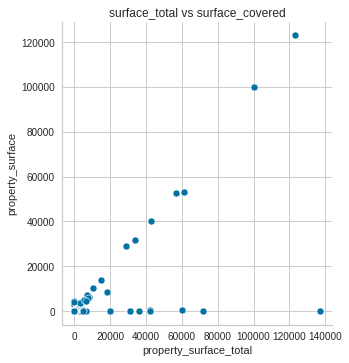

In [824]:
graf_relplot=sns.relplot(data=ds_train, x="property_surface_total", y="property_surface_covered").set(title="surface_total vs surface_covered",xlabel='property_surface_total',ylabel='property_surface')

#### Price y Rooms

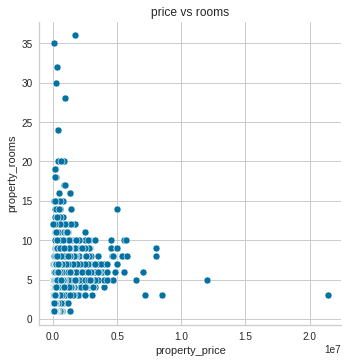

In [825]:
graf_relplot=sns.relplot(data=ds_train, x="property_price", y="property_rooms").set(title="price vs rooms",xlabel='property_price',ylabel='property_rooms')

Precio promedio de propiedad por Barrio


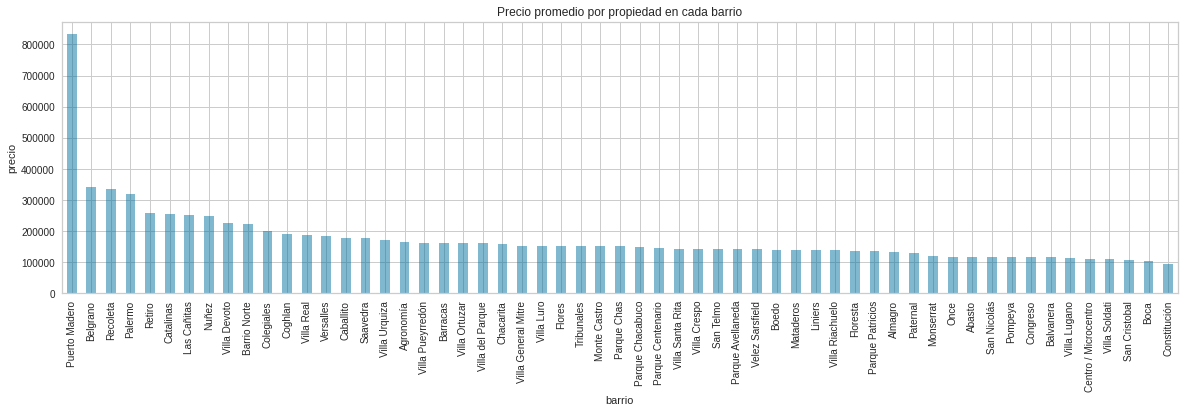

In [826]:
ds_precio_prom = ds_train.groupby(["place_l3"])["property_price"].mean().sort_values(ascending=False)
grf_ds=ds_precio_prom.plot.bar(alpha=0.5 , title="Precio promedio por propiedad en cada barrio" , xlabel="barrio" , ylabel="precio", figsize=(20,5))

### Conslusiones exploracion inicial

El analisis al que podemos llegar con la exoloracion inicial realizada es:

- Tenemos mucha mayor cantidad de propiedades de tipo "Departamento", que de tipo "Casa" o "PH"
- Mucha cantidad de propiedades en zonas como Palermo, Belgrano, Caballito y Recoleta
- La zona con el promedio de precios mas alto es Puerto Madero 
- Encontramos columnas en el dataset que debido a su falta de utilidad en el trabajo o su alto porcentaje de valores faltantes, decidimos sacarlos del dataset

## Datos faltantes


### Análisis de datos faltantes

Porcentaje de datos faltantes por columna

In [827]:
filas_totales=ds_train.shape[0]
print(ds_train.isna().sum()/filas_totales*100)

latitud                       3.986790
longitud                      3.986790
place_l3                      0.429714
place_l4                     96.045040
place_l5                    100.000000
place_l6                    100.000000
property_type                 0.000000
property_rooms                1.102137
property_bedrooms            11.591666
property_surface_total        5.099537
property_surface_covered      3.587581
property_price                0.000000
dtype: float64


Cantidad de datos faltantes por columna

In [828]:
print(ds_train.isna().sum())

latitud                      3006
longitud                     3006
place_l3                      324
place_l4                    72417
place_l5                    75399
place_l6                    75399
property_type                   0
property_rooms                831
property_bedrooms            8740
property_surface_total       3845
property_surface_covered     2705
property_price                  0
dtype: int64


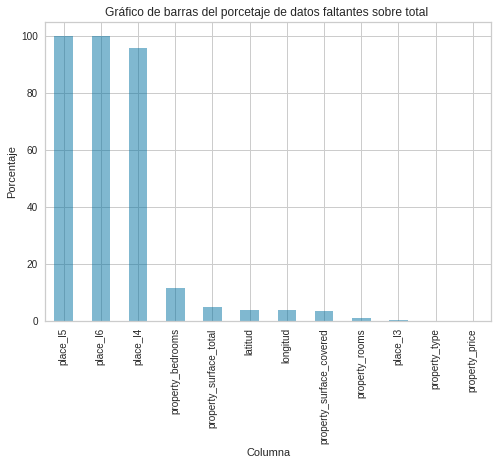

In [829]:
ds_porcentaje = ds_train.isna().sum()/filas_totales*100
ds_porcentaje = ds_porcentaje.sort_values(ascending=False)
grf_ds = ds_porcentaje.plot.bar(alpha=0.5 , title="Gráfico de barras del porcetaje de datos faltantes sobre total " , xlabel="Columna" , ylabel="Porcentaje")

Tomando en cuenta estos resultados, decidimos eliminar las columnas l4 , l5 y l6 debido a que el porcentaje de datos faltantes es total o casi total. En el caso de l5 y l6 son de 100 por ciento por lo cual no se podria completar y en el caso de l4 son las subdivisiones barriales de los cuales muchos no poseen.


In [830]:

columnas_a_elimianar = ["place_l4","place_l5","place_l6"]
def eliminar_columnas_nans(dataset):
    dataset.drop(columns = columnas_a_elimianar, inplace = True)
    
eliminar_columnas_nans(ds_train)
eliminar_columnas_nans(ds_test)

In [831]:
ds_train.head()

latitud   longitud  place_l3 property_type  property_rooms  \
280087 -34.601807 -58.469965  Paternal  Departamento             2.0   
256350 -34.580088 -58.424965   Palermo  Departamento             2.0   
135168 -34.551481 -58.452358  Belgrano  Departamento             1.0   
227831 -34.632290 -58.464844    Flores  Departamento             5.0   
409101 -34.549279 -58.463074     Nuñez  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
280087                1.0                    53.0                      49.0   
256350                1.0                    35.0                      35.0   
135168                1.0                    25.0                      20.0   
227831                3.0                    75.0                      75.0   
409101                1.0                    46.0                      34.0   

        property_price  
280087         80000.0  
256350         79900.0  
135168         69000.0  
227831        150000.0  
409101         85000.0

#### Latitud y Longitud

Grafico de cantidad de datos faltantes respecto al total

In [832]:
lat_long = ds_train[["latitud", "longitud"]].isna()

lat_long.loc[lat_long.loc[:,"latitud"]==True,"latitud"]="nans"
lat_long.loc[lat_long.loc[:,"latitud"]==False,"latitud"]="no_nans"

lat_long.loc[lat_long.loc[:,"longitud"]==True,"longitud"]="nans"
lat_long.loc[lat_long.loc[:,"longitud"]==False,"longitud"]="no_nans"

lat_long.head()

latitud longitud
280087  no_nans  no_nans
256350  no_nans  no_nans
135168  no_nans  no_nans
227831  no_nans  no_nans
409101  no_nans  no_nans

Grafico Latitud

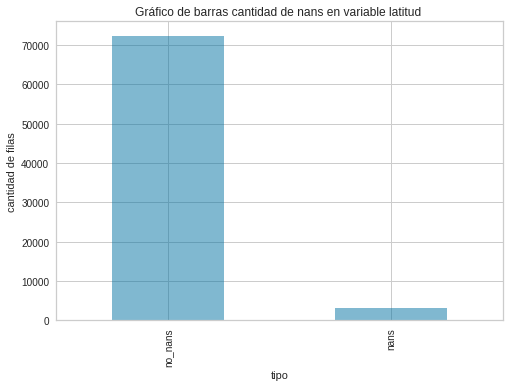

In [833]:
grf_ds=lat_long["latitud"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable latitud " , xlabel="tipo" , ylabel="cantidad de filas")

In [834]:
cant_no_nans = lat_long["latitud"].value_counts().to_list()[0]
cant_nans = lat_long["latitud"].value_counts().to_list()[1]

print("Cantidad total del dataset: " + str(cant_no_nans + cant_nans))
print("Cantidad total de nans: " + str(cant_nans))

Cantidad total del dataset: 75399
Cantidad total de nans: 3006


Grafico longitud

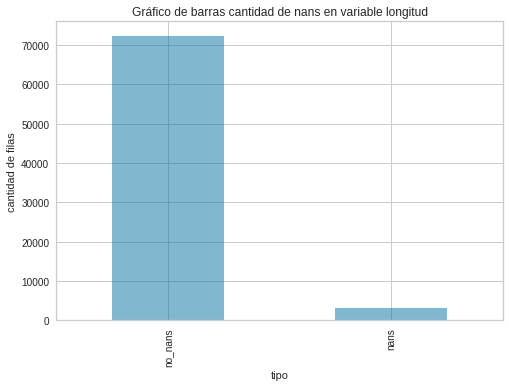

In [835]:
grf_ds=lat_long["longitud"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable longitud" , xlabel="tipo" , ylabel="cantidad de filas")

In [836]:
cant_no_nans = lat_long["longitud"].value_counts().to_list()[0]
cant_nans = lat_long["longitud"].value_counts().to_list()[1]

print("Cantidad total del dataset: " + str(cant_no_nans + cant_nans))
print("Cantidad total de nans: " + str(cant_nans))

Cantidad total del dataset: 75399
Cantidad total de nans: 3006


#### Barrio (place_l3)

In [837]:
barrio = ds_train[["place_l3"]].isna()

barrio.loc[barrio.loc[:,"place_l3"]==True,"place_l3"]= "nans"
barrio.loc[barrio.loc[:,"place_l3"]==False,"place_l3"]= "no_nans"

barrio.head()

place_l3
280087  no_nans
256350  no_nans
135168  no_nans
227831  no_nans
409101  no_nans

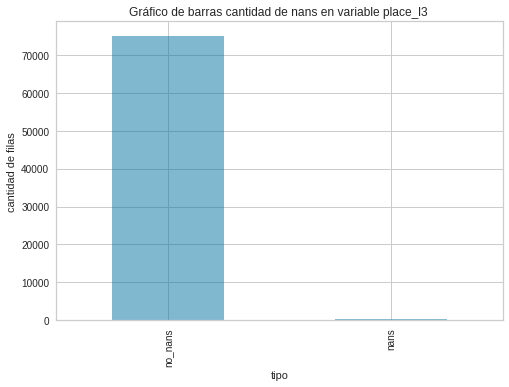

In [838]:
grf_ds=barrio["place_l3"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable place_l3 " , xlabel="tipo" , ylabel="cantidad de filas")

In [839]:
cant_no_nans = barrio["place_l3"].value_counts().to_list()[0]
cant_nans = barrio["place_l3"].value_counts().to_list()[1]

print("Cantidad total del dataset: " + str(cant_no_nans + cant_nans))
print("Cantidad total de nans: " + str(cant_nans))

Cantidad total del dataset: 75399
Cantidad total de nans: 324


#### Rooms & bedrooms

In [840]:
rooms_bedrooms = ds_train[["property_rooms", "property_bedrooms"]].isna()

rooms_bedrooms.loc[rooms_bedrooms.loc[:,"property_rooms"]==True,"property_rooms"]="nans"
rooms_bedrooms.loc[rooms_bedrooms.loc[:,"property_rooms"]==False,"property_rooms"]="no_nans"

rooms_bedrooms.loc[rooms_bedrooms.loc[:,"property_bedrooms"]==True,"property_bedrooms"]="nans"
rooms_bedrooms.loc[rooms_bedrooms.loc[:,"property_bedrooms"]==False,"property_bedrooms"]="no_nans"

rooms_bedrooms.head()

property_rooms property_bedrooms
280087        no_nans           no_nans
256350        no_nans           no_nans
135168        no_nans           no_nans
227831        no_nans           no_nans
409101        no_nans           no_nans

Variable property_rooms

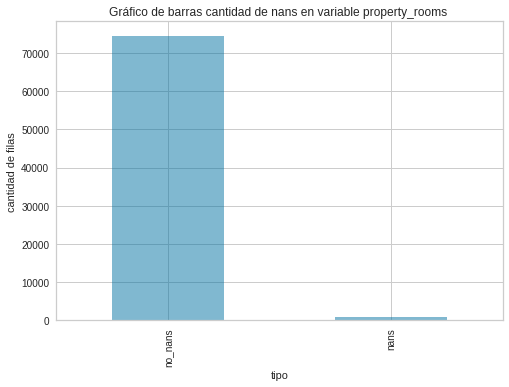

In [841]:
grf_ds=rooms_bedrooms["property_rooms"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable property_rooms " , xlabel="tipo" , ylabel="cantidad de filas")

In [842]:
cant_no_nans = rooms_bedrooms["property_rooms"].value_counts().to_list()[0]
cant_nans = rooms_bedrooms["property_rooms"].value_counts().to_list()[1]

print("Cantidad total del dataset: " + str(cant_no_nans + cant_nans))
print("Cantidad total de nans: " + str(cant_nans))

Cantidad total del dataset: 75399
Cantidad total de nans: 831


Variable property_bedrooms

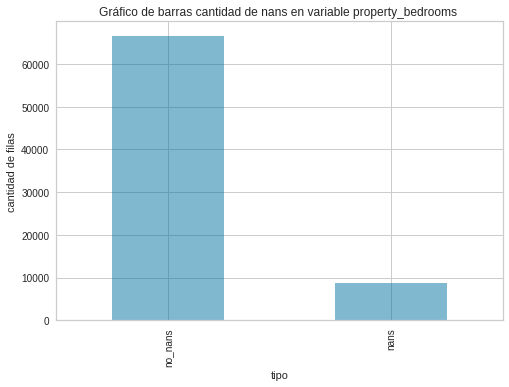

In [843]:
grf_ds=rooms_bedrooms["property_bedrooms"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable property_bedrooms " , xlabel="tipo" , ylabel="cantidad de filas")

In [844]:
cant_no_nans = rooms_bedrooms["property_bedrooms"].value_counts().to_list()[0]
cant_nans = rooms_bedrooms["property_bedrooms"].value_counts().to_list()[1]

print("Cantidad total del dataset: " + str(cant_no_nans + cant_nans))
print("Cantidad total de nans: " + str(cant_nans))

Cantidad total del dataset: 75399
Cantidad total de nans: 8740


#### Surface Total & Covered

In [845]:
total_covered = ds_train[["property_surface_total", "property_surface_covered"]].isna()

total_covered.loc[total_covered.loc[:,"property_surface_total"]==True,"property_surface_total"]="nans"
total_covered.loc[total_covered.loc[:,"property_surface_total"]==False,"property_surface_total"]="no_nans"

total_covered.loc[total_covered.loc[:,"property_surface_covered"]==True,"property_surface_covered"]="nans"
total_covered.loc[total_covered.loc[:,"property_surface_covered"]==False,"property_surface_covered"]="no_nans"

total_covered.head()

property_surface_total property_surface_covered
280087                no_nans                  no_nans
256350                no_nans                  no_nans
135168                no_nans                  no_nans
227831                no_nans                  no_nans
409101                no_nans                  no_nans

Variable property_surface_total

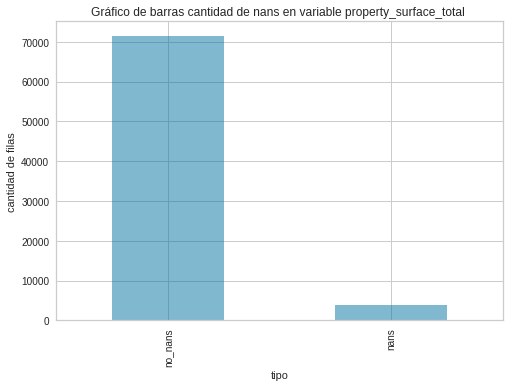

In [846]:
grf_ds=total_covered["property_surface_total"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable property_surface_total " , xlabel="tipo" , ylabel="cantidad de filas")

In [847]:
cant_no_nans = total_covered["property_surface_total"].value_counts().to_list()[0]
cant_nans = total_covered["property_surface_total"].value_counts().to_list()[1]

print("Cantidad total del dataset: " + str(cant_no_nans + cant_nans))
print("Cantidad total de nans: " + str(cant_nans))

Cantidad total del dataset: 75399
Cantidad total de nans: 3845


Variable property_surface_covered

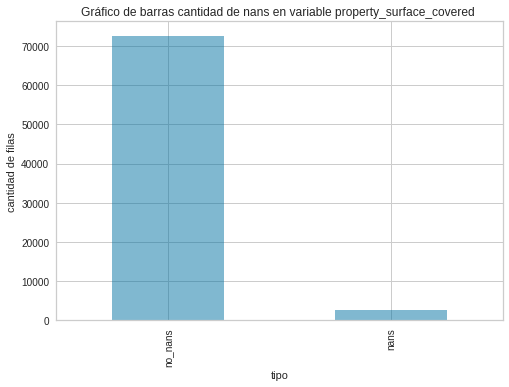

In [848]:
grf_ds=total_covered["property_surface_covered"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable property_surface_covered " , xlabel="tipo" , ylabel="cantidad de filas")

In [849]:
cant_no_nans = total_covered["property_surface_covered"].value_counts().to_list()[0]
cant_nans = total_covered["property_surface_covered"].value_counts().to_list()[1]

print("Cantidad total del dataset: " + str(cant_no_nans + cant_nans))
print("Cantidad total de nans: " + str(cant_nans))

Cantidad total del dataset: 75399
Cantidad total de nans: 2705


#### Precio

In [850]:
precio = ds_train[["property_price"]].isna()

precio.loc[precio.loc[:,"property_price"]==True,"property_price"]= "nans"
precio.loc[precio.loc[:,"property_price"]==False,"property_price"]= "no_nans"

precio.head()

property_price
280087        no_nans
256350        no_nans
135168        no_nans
227831        no_nans
409101        no_nans

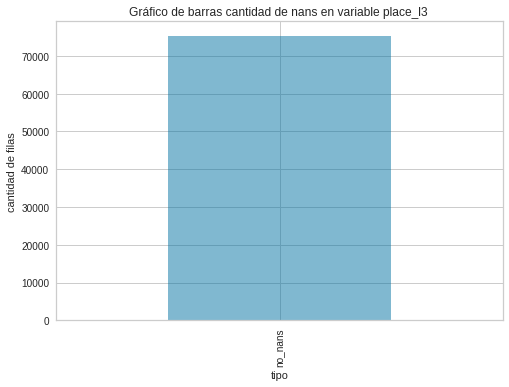

In [851]:
grf_ds=precio["property_price"].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans en variable place_l3 " , xlabel="tipo" , ylabel="cantidad de filas")

Esta variable no posee valores nulos, al igual que "property_type"

### Datos faltantes a nivel fila

Cantidad de filas que poseen datos faltantes

In [852]:
filas_cantidad_nan = pd.DataFrame(ds_train).isna().sum(axis=1).to_frame("cantidad")
cantidad = len(filas_cantidad_nan[filas_cantidad_nan["cantidad"] > 0])
print(f"Hay {cantidad} lineas que poseen uno o mas valores faltantes")

Hay 17072 lineas que poseen uno o mas valores faltantes


Grafico de barras de cantidad de filas con diferente cantidad de valores nulos

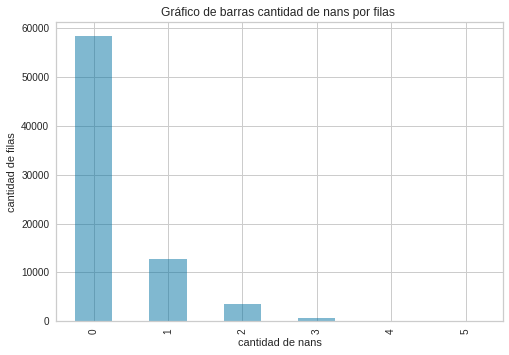

In [853]:
grf_ds=filas_cantidad_nan['cantidad'].value_counts().plot.bar(alpha=0.5 , title="Gráfico de barras cantidad de nans por filas " , xlabel="cantidad de nans" , ylabel="cantidad de filas")

In [854]:
cant_nans_fila = filas_cantidad_nan['cantidad'].value_counts()
cero = cant_nans_fila[0]
uno = cant_nans_fila[1]
dos =  cant_nans_fila[2]
tres =  cant_nans_fila[3]
cuatro = cant_nans_fila[4]
cinco = cant_nans_fila[5]

### Estartegias para rellenar valores faltantes

#### Cold deck para rellenar barrios

Dado que poseemos la latitud y longitud de casi todas las propiedades, vamos a utilizar imputacion Cold Deck, para rellenar los datos faltantes de la columna "place_l3"

Primero procedemos imputando los cualitativos, que en este caso solo es el place_l3.
Utilizando un archivo csv proporcionado por el gobierno de la Ciudad Autonoma de Buenos Aires, el cual nos proporcionorá el nombre de la localidad usando latitud y longitud, mediante la utilizacion de Polygon.
https://data.buenosaires.gob.ar/dataset/barrios


In [855]:
ds_barrios = pd.read_csv('barrios.csv', header=0,sep=';')

from shapely.geometry import MultiPolygon, Polygon, Point
from shapely import wkt
ds_barrios.WKT = ds_barrios.WKT

def rellenar_barrios(dataset):
    for index, registro_prop in dataset.iterrows():
        if  type(registro_prop["place_l3"]) is str:
            continue
        for index_, registro_barrio in ds_barrios.iterrows():
            if wkt.loads(registro_barrio.WKT).covers(Point(registro_prop.longitud,registro_prop.latitud)):
                barrio_aux = registro_barrio['BARRIO']
                dataset.loc[index, 'place_l3'] = barrio_aux

rellenar_barrios(ds_train)
rellenar_barrios(ds_test)

Me fijo si quedo algun place_l3 incompleto.


In [856]:
ds_train["place_l3"].isna().value_counts()

False    75117
True       282
Name: place_l3, dtype: int64

Eliminamos aquellas que no tengan place_l3 porque no se pueden completar por el barrio o tienen mal el dato ej: dato con latitud -31.678 y longitud -63.87964 pertenece a Cordoba pero place_l2 es Capital federal por lo que puede ser que el dato este subido erroneamente. 

Tambien eliminamos los registros sin latitud ni longitud porque no es posible saber su dato exacto y puede ser un registro mal cargado. 

Y vemos cuantos datos faltantes quedan.


In [857]:
def eliminar_fallidos_colddeck(dataset):
    dataset.dropna(subset=["place_l3", "longitud", "latitud"], inplace=True)

eliminar_fallidos_colddeck(ds_train)
eliminar_fallidos_colddeck(ds_test)

Verificamos que no hayan nans en las variables
- Latitud
- Longitud
- place_l3

In [858]:
filas_totales=ds_train.shape[0]
print(ds_train.isna().sum()/filas_totales*100)


latitud                      0.000000
longitud                     0.000000
place_l3                     0.000000
property_type                0.000000
property_rooms               0.971774
property_bedrooms           11.543626
property_surface_total       4.994532
property_surface_covered     3.568709
property_price               0.000000
dtype: float64


In [859]:
filas_totales=ds_test.shape[0]
print(ds_test.isna().sum()/filas_totales*100)


latitud                      0.000000
longitud                     0.000000
place_l3                     0.000000
property_type                0.000000
property_rooms               0.923468
property_bedrooms           11.828135
property_surface_total       5.203495
property_surface_covered     3.395267
property_price               0.000000
dtype: float64


#### Mice para rellenar 
- property_surface_total
- property_surface_covered
- property_rooms
- property_bedrooms

Verificamos que no hayan duplicados y los eliminamos

In [860]:
print(ds_train[ds_train.duplicated(keep=False)]) 
print(ds_test[ds_test.duplicated(keep=False)]) 

          latitud   longitud       place_l3 property_type  property_rooms  \
10032  -34.571950 -58.448955     Colegiales  Departamento             2.0   
413132 -34.589588 -58.431352        Palermo          Casa             5.0   
251584 -34.587275 -58.513193   Villa Devoto            PH             5.0   
424110 -34.636947 -58.417606          Boedo  Departamento             2.0   
147196 -34.604188 -58.399590           Once  Departamento             3.0   
...           ...        ...            ...           ...             ...   
454839 -34.597760 -58.440873   Villa Crespo  Departamento             3.0   
237552 -34.634047 -58.454754         Flores          Casa             7.0   
269754 -34.548690 -58.471168       Saavedra  Departamento             1.0   
212425 -34.601109 -58.425161        Almagro  Departamento             2.0   
335036 -34.577672 -58.495749  Villa Urquiza            PH             2.0   

        property_bedrooms  property_surface_total  property_surface_covered

Nos fijamos si hay algun valor sospechoso que sea negativo en train

In [861]:
columnas_con_numeros = ['property_price', 'property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']
(ds_train[columnas_con_numeros] <= 0).any().to_frame('Menor que 0 ?')

Menor que 0 ?
property_price                    False
property_surface_total            False
property_surface_covered          False
property_rooms                    False
property_bedrooms                  True

Property_bedrooms tiene numero negativo, asi que veo cuantos hay

In [862]:
ds_prop_filtrado[ds_prop_filtrado['property_bedrooms'] < 1]

id  start_date    end_date  created_on  \
406880  3WI+zCCMeb9TR5kOBm7rhg==  2021-01-07  2021-03-18  2021-01-07   

          latitud   longitud         place_l2       place_l3 place_l4  \
406880 -34.577595 -58.495185  Capital Federal  Villa Urquiza      NaN   

       place_l5  place_l6 operation property_type  property_rooms  \
406880      NaN       NaN     Venta  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
406880               -1.0                    61.0                      43.0   

        property_price property_currency  \
406880        125000.0               USD   

                                           property_title  
406880  Jardines de Roosevelt - Hermoso 3 ambientes co...

Solo hay uno asi que se lo coloca en nan porque no condiciona el analisis pero si el dato es incorrecto

In [863]:
ds_train.loc[ds_prop_filtrado['property_bedrooms'] < 1,'property_bedrooms'] = np.nan

Hago lo mismo para el dataset de test

In [864]:
columnas_con_numeros = ['property_price', 'property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']
(ds_test[columnas_con_numeros] <= 0).any().to_frame('Menor que 0 ?')

Menor que 0 ?
property_price                    False
property_surface_total            False
property_surface_covered          False
property_rooms                    False
property_bedrooms                 False

No hay numeros negativos en ds_test

guardo una copia pre imputacion para despues

In [865]:
ds_copia_pre_imputacion = ds_train.copy()

Luego imputaremos los datos cuantitativos faltantes utilizando el metodo MICE.


In [866]:
columnas =['property_surface_total','property_surface_covered','property_rooms','property_bedrooms'] 
lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=0,imputation_order='roman',initial_strategy = "mean", min_value=1)

def rellenar_con_mice(train, test):
    df_eliminar_nans_op3 = train[columnas].copy()
    train[columnas] = imp.fit_transform(df_eliminar_nans_op3)
    test[columnas] = imp.transform(test[columnas])

rellenar_con_mice(ds_train, ds_test)

ds_train[['property_rooms','property_bedrooms']] = ds_train[['property_rooms','property_bedrooms']].round()
ds_test[['property_rooms','property_bedrooms']] = ds_test[['property_rooms','property_bedrooms']].round()

verifico haber rellando los espacios nulos

In [867]:
filas_totales = ds_train.shape[0]
print(ds_train.isna().sum()/filas_totales*100)

latitud                     0.0
longitud                    0.0
place_l3                    0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_price              0.0
dtype: float64


### Comparamos distribuciones de los atributos que imputamos y comparamos con la distribucion anterior a la imputacion

#### Comparamos property_bedrooms


[Text(0.5, 1.0, 'Boxplot variable property_bedrooms post imputacion')]

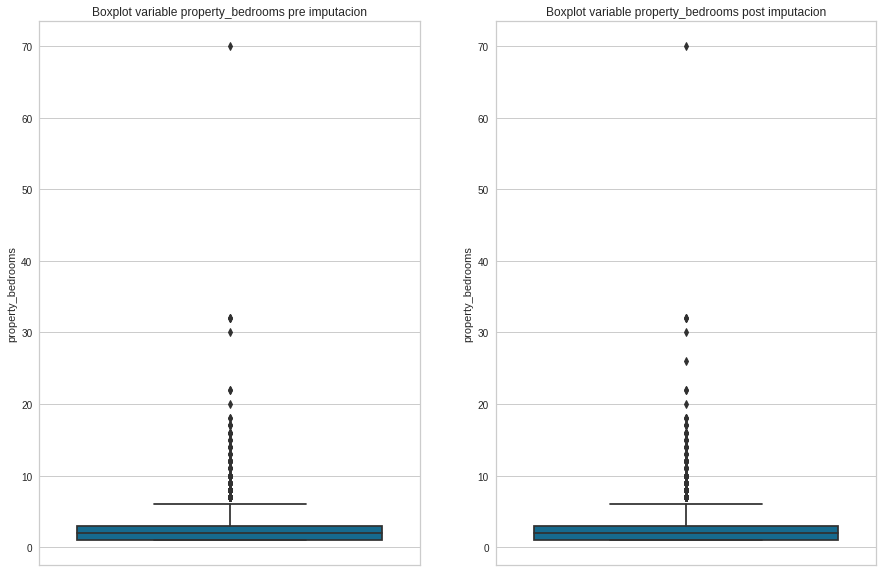

In [868]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_bedrooms", data=ds_copia_pre_imputacion, ax=axes[0]).set( title="Boxplot variable property_bedrooms pre imputacion")
sns.boxplot(y="property_bedrooms", data=ds_train, ax=axes[1]).set( title="Boxplot variable property_bedrooms post imputacion")


Si observamos el Boxplot de ambos dataset, podemos ver que son muy similares, excepto por una observacion entre el 20 y 30, por lo que podemos asumir que las imputacions fueron dentro del rango ya establecido de dormitorios. No se imputaron con valores extremadamente bajos ni altos.

In [869]:
pre_imputacion_bedrooms = ds_copia_pre_imputacion["property_bedrooms"].value_counts().to_frame().reset_index()
pre_imputacion_bedrooms = pre_imputacion_bedrooms.rename({'index': 'bedrooms', "property_bedrooms" : "cantidad"}, axis=1)
pre_imputacion_bedrooms = pre_imputacion_bedrooms.sort_values('bedrooms',ascending=True)

post_imputacion_bedrooms = ds_train["property_bedrooms"].value_counts().to_frame().reset_index()
post_imputacion_bedrooms = post_imputacion_bedrooms.rename({'index': 'bedrooms', "property_bedrooms" : "cantidad"}, axis=1)
post_imputacion_bedrooms = post_imputacion_bedrooms.sort_values('bedrooms',ascending=True)

In [870]:
pre_imputacion_bedrooms.head()

bedrooms  cantidad
0       1.0     24535
1       2.0     21217
2       3.0     13449
3       4.0      3615
4       5.0       685

In [871]:
post_imputacion_bedrooms.head()

bedrooms  cantidad
0       1.0     32142
1       2.0     21719
2       3.0     13620
3       4.0      3637
4       5.0       697

Vemos cantidad de imputaciones realizadas

In [872]:
print(ds_copia_pre_imputacion.isna().sum())

latitud                        0
longitud                       0
place_l3                       0
property_type                  0
property_rooms               702
property_bedrooms           8340
property_surface_total      3608
property_surface_covered    2578
property_price                 0
dtype: int64


Previo a la imputacion de mice, habia 8340 registros con valores nulos en "property_bedrooms", todos fueron rellenados. Observando los datasets
pre_imputacion_bedrooms y post__imputacion_bedrooms notamos que:

- 7607 registros se imputaron con el valor de un dormitorio
- 502 registros se imputaron con el valor de dos dormitorios
- 171 registros se imputaron con el valor de tres dormitorios
- 22 registros se imputaron con el valor de cuatro dormitorios
- etc

Esto nos indica que la mayoria de los registros con valores nans en "property_bedrooms" fueron rellenados con un dormitorio

#### Comparamos property_rooms

[Text(0.5, 1.0, 'Boxplot variable property_rooms post imputacion')]

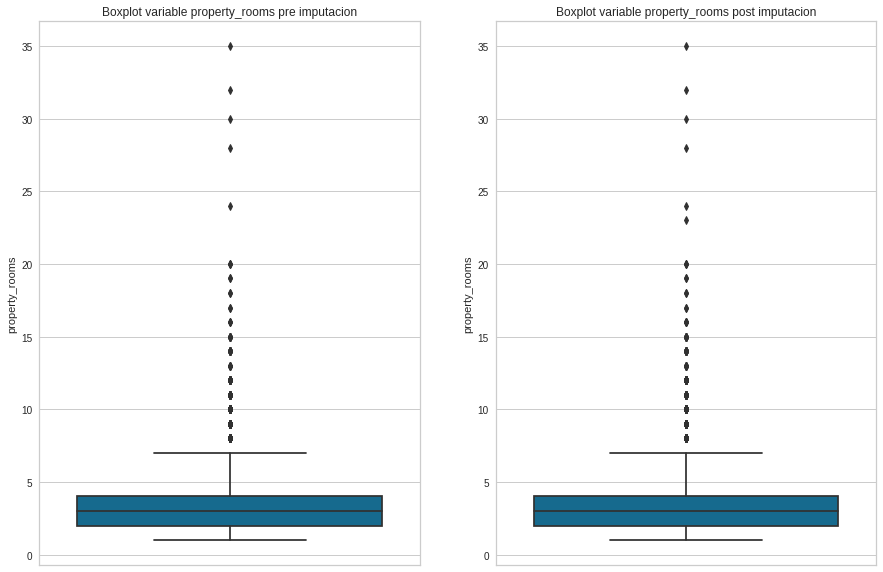

In [873]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_rooms", data=ds_copia_pre_imputacion, ax=axes[0]).set( title="Boxplot variable property_rooms pre imputacion")
sns.boxplot(y="property_rooms", data=ds_train, ax=axes[1]).set( title="Boxplot variable property_rooms post imputacion")

<AxesSubplot:>

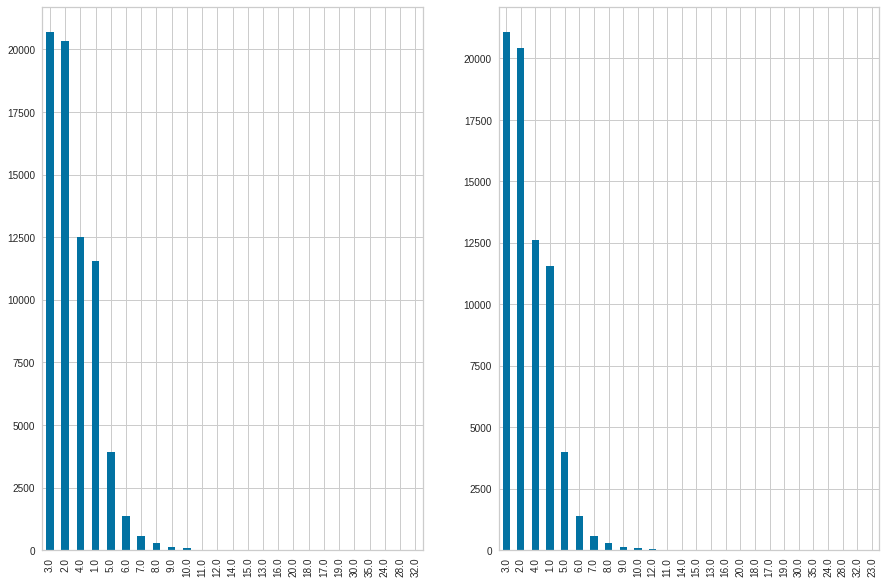

In [874]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
ds_copia_pre_imputacion["property_rooms"].value_counts().plot.bar(ax=axes[0])
ds_train["property_rooms"].round().value_counts().plot.bar(ax=axes[1])

Analizamos valores imputados


In [875]:
pre_imputacion_rooms = ds_copia_pre_imputacion["property_rooms"].value_counts().to_frame().reset_index()
pre_imputacion_rooms = pre_imputacion_rooms.rename({'index': 'rooms', "property_rooms" : "cantidad"}, axis=1)
pre_imputacion_rooms = pre_imputacion_rooms.sort_values('rooms',ascending=True)

post_imputacion_rooms = ds_train["property_rooms"].value_counts().to_frame().reset_index()
post_imputacion_rooms = post_imputacion_rooms.rename({'index': 'rooms', "property_rooms" : "cantidad"}, axis=1)
post_imputacion_rooms = post_imputacion_rooms.sort_values('rooms',ascending=True)

In [876]:
pre_imputacion_rooms.head()

rooms  cantidad
3    1.0     11539
1    2.0     20357
0    3.0     20680
2    4.0     12528
4    5.0      3932

In [877]:
post_imputacion_rooms.head()

rooms  cantidad
3    1.0     11539
1    2.0     20432
0    3.0     21056
2    4.0     12633
4    5.0      4006

Vemos cantidad de imputaciones realizadas

In [878]:
print(ds_copia_pre_imputacion.isna().sum())

latitud                        0
longitud                       0
place_l3                       0
property_type                  0
property_rooms               702
property_bedrooms           8340
property_surface_total      3608
property_surface_covered    2578
property_price                 0
dtype: int64


Previo a la imputacion de mice, habia 702 registros con valores nulos en "property_rooms", todos fueron rellenados. Observando los datasets
pre_imputacion_rooms y post__imputacion_rooms notamos que:

- 0 registros se imputaron con el valor de una habitacion
- 75 registros se imputaron con el valor de dos habitaciones
- 376 registros se imputaron con el valor de tres habitaciones
- 105 registros se imputaron con el valor de cuatro habitaciones
- 74 registros se imputaron con el valor de cinco habitaciones
- etc

Esto nos indica que la mayoria de los registros con valores nans en "property_bedrooms" fueron rellenados con tres habitaciones

#### Comparamos property_surface_total

[Text(0.5, 1.0, 'Boxplot variable property_surface_total post imputacion')]

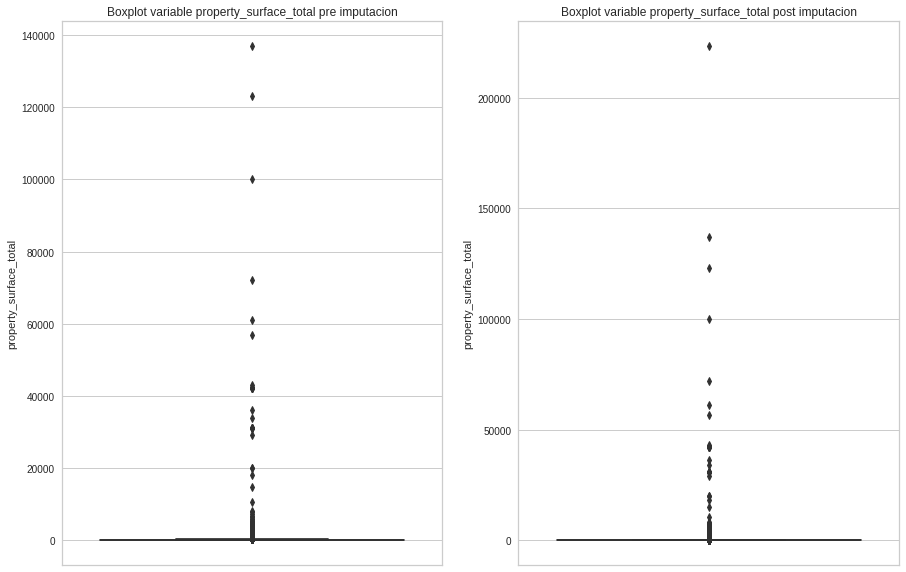

In [879]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_surface_total", data=ds_copia_pre_imputacion, ax=axes[0]).set( title="Boxplot variable property_surface_total pre imputacion")
sns.boxplot(y="property_surface_total", data=ds_train, ax=axes[1]).set( title="Boxplot variable property_surface_total post imputacion")


Si observamos el grafico vemos que hubo valores que se impurtaron de alto valor, por ejemplo el registro que tiene un valor de mas de 200000 metros cuadrados. Puede ser un registro mal clasificado, mas adelante se lo estudiara para saber si puede ser tomado como un outlier y eliminarlo.

In [880]:
promedio_pre_imputacion = ds_copia_pre_imputacion["property_surface_total"].mean()
promedio_post_imputacion = ds_train["property_surface_total"].mean()

print("El promedio pre imputacion de la variable property_surface_total tiene un valor de: " + str(promedio_pre_imputacion))
print("El promedio post imputacion de la variable property_surface_total tiene un valor de: " + str(promedio_post_imputacion))

El promedio pre imputacion de la variable property_surface_total tiene un valor de: 111.32925354431671
El promedio post imputacion de la variable property_surface_total tiene un valor de: 114.65469229265004


Podemos observar que es muy parecido el promedio observado por los dos datasets, pero el post imputacion es un poco mas grande. 
Podiramos pensar que los valos que se imputaron fueron probablementa mas grandes que el promedio

#### Comparamos property_surface_covered

[Text(0.5, 1.0, 'Boxplot variable property_surface_covered post imputacion')]

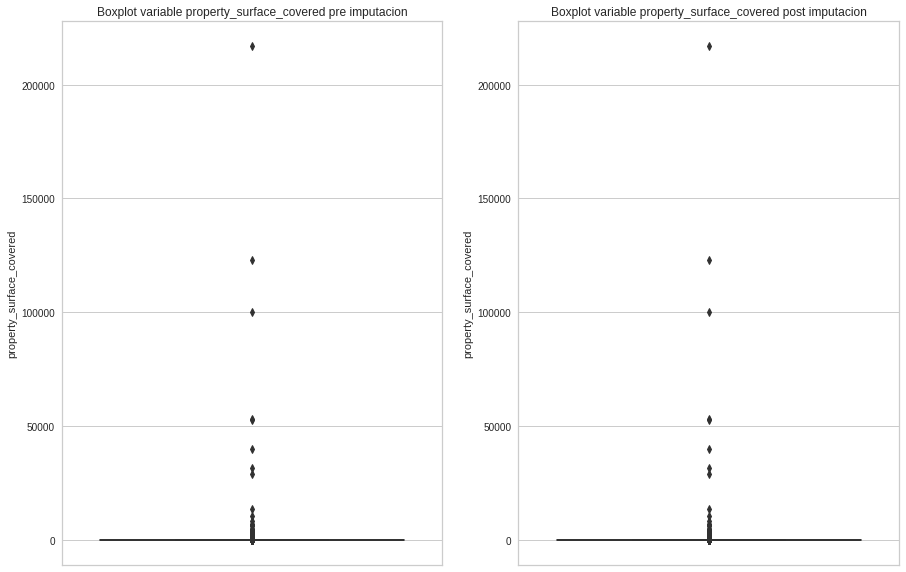

In [881]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_surface_covered", data=ds_copia_pre_imputacion, ax=axes[0]).set( title="Boxplot variable property_surface_covered pre imputacion")
sns.boxplot(y="property_surface_covered", data=ds_train, ax=axes[1]).set( title="Boxplot variable property_surface_covered post imputacion")


En este caso, al contrario de property_surface_total, no vemos en el grafico valores que llamen la atencion. 

In [882]:
promedio_pre_imputacion = ds_copia_pre_imputacion["property_surface_covered"].mean()
promedio_post_imputacion = ds_train["property_surface_covered"].mean()

print("El promedio pre imputacion de la variable property_surface_covered tiene un valor de: " + str(promedio_pre_imputacion))
print("El promedio post imputacion de la variable property_surface_covered tiene un valor de: " + str(promedio_post_imputacion))

El promedio pre imputacion de la variable property_surface_covered tiene un valor de: 88.65171329725385
El promedio post imputacion de la variable property_surface_covered tiene un valor de: 88.14380796447836


En este caso es lo contrario, el promedio post imputacion tiene un valor mas bajo, aunque muy pequeño.

## Analizar la existencia de valores atípicos


### Detectar valores atípicos en los datos en forma univariada


Vamos a analizar los valores atipicos con Z-score:

- Considereremos como outliers a las observaciones que posean 3 o mas desviaciones estandar de la media muestral
- Ese valor "3" es el umbral que elegimos para detectar outliers. Conocida como la "regla de oro"

In [883]:
umbral = 3

Calculo quartiles que me serviran en el analisis

In [884]:
columnas = ["property_rooms", "property_bedrooms","property_surface_total", "property_surface_covered", "property_price"]
ds_cuantitativo = ds_train.loc[:,columnas]
ds_rangos = pd.DataFrame()
ds_rangos["q1"] = ds_cuantitativo.quantile([.25]).iloc[0]
ds_rangos["q3"] = ds_cuantitativo.quantile([.75]).iloc[0]
ds_rangos["max_whisker"] = ds_rangos["q3"] + 1.5 * (ds_rangos["q3"] - ds_rangos["q1"])
ds_rangos

q1        q3  max_whisker
property_rooms                2.0       4.0          7.0
property_bedrooms             1.0       3.0          6.0
property_surface_total       45.0     105.0        195.0
property_surface_covered     40.0      88.0        160.0
property_price            95000.0  235000.0     445000.0

#### Analizamos property_rooms


In [885]:
ds_train['z_rooms'] = st.zscore(ds_train.property_rooms) 

ds_test['z_rooms'] = st.zscore(ds_test.property_rooms) 

 - Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" 

In [886]:
ds_outliers_rooms = ds_train[ds_train['z_rooms'] > umbral ]
ds_outliers_rooms.head()

latitud   longitud  place_l3 property_type  property_rooms  \
9661   -34.563353 -58.444035  Belgrano  Departamento            12.0   
201345 -34.651881 -58.409308   Pompeya          Casa             9.0   
197660 -34.591766 -58.391875  Recoleta  Departamento             9.0   
331525 -34.629600 -58.364400      Boca  Departamento             8.0   
358714 -34.590923 -58.384214  Recoleta  Departamento             9.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
9661                  5.0              435.000000                     435.0   
201345                8.0              404.634203                     290.0   
197660                5.0              404.038337                     330.0   
331525                6.0              166.000000                     144.0   
358714                4.0              668.000000                     668.0   

        property_price   z_rooms  
9661          850000.0  6.439138  
201345        400000.0  4.332828  
197660       1250000.0  4.332828  
331525        190000.0  3.630724  
358714       5000000.0  4.332828

Vemos si hay algun valor negativo

In [887]:
ds_train[ds_train['z_rooms'] < - umbral ]

Empty DataFrame
Columns: [latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms]
Index: []

Grafico Boxplot de variable property_rooms


[Text(0.5, 1.0, 'Boxplot variable property_rooms')]

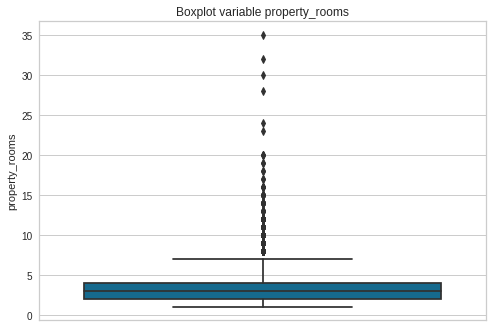

In [888]:
sns.boxplot(y=ds_train.property_rooms).set( title="Boxplot variable property_rooms")

Valor maximo de habitaciones antes de ser outlier

In [889]:
print("Podemos observar que el valor maximo que puede tomar un registro en la variable property_rooms antes de ser outlier en el grafico es: " + str(ds_rangos["max_whisker"][0]))

Podemos observar que el valor maximo que puede tomar un registro en la variable property_rooms antes de ser outlier en el grafico es: 7.0


Me fijo cantidad de property_rooms de los outliers detectados por z_score

In [890]:
ds_outliers_rooms["property_rooms"].value_counts()

8.0     277
9.0     134
10.0     80
12.0     35
11.0     26
14.0     17
15.0     11
13.0      8
16.0      5
20.0      3
19.0      2
18.0      2
17.0      2
32.0      1
28.0      1
30.0      1
24.0      1
35.0      1
23.0      1
Name: property_rooms, dtype: int64

Observamos los outliers despues de 7 habitaciones, son los valores que superan a los bigotes superiores e inferioires del grafico boxplot, en este caso solo superiores.
Vemos como coincide con los valores de los outliers detectados por z-score, en donde todos los outliers tienen un numero de habitaciones mayor a 7.

Cantidad de outliers detectada en la variable property_rooms

In [891]:
print("Detectamos un total de: " + str(ds_outliers_rooms.shape[0]) + " outliers en la variable property_rooms")

Detectamos un total de: 608 outliers en la variable property_rooms


#### Anlalizamos property_bedrooms


In [892]:
ds_train['z_bedrooms'] = st.zscore(ds_train.property_bedrooms)

ds_test['z_bedrooms'] = st.zscore(ds_test.property_bedrooms)

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers


In [893]:
ds_outliers_bedrooms = ds_train[ds_train['z_bedrooms'] > umbral ]
ds_outliers_bedrooms.head()

latitud   longitud       place_l3 property_type  property_rooms  \
346603 -34.609960 -58.401123           Once  Departamento             7.0   
340949 -34.579491 -58.475587  Villa Ortuzar          Casa             7.0   
236625 -34.626670 -58.439150      Caballito          Casa             7.0   
201345 -34.651881 -58.409308        Pompeya          Casa             9.0   
130208 -34.604930 -58.440416   Villa Crespo          Casa             5.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
346603                6.0              244.000000                     244.0   
340949                6.0              243.860483                     160.0   
236625                6.0              300.285551                     215.0   
201345                8.0              404.634203                     290.0   
130208                8.0              540.000000                     540.0   

        property_price   z_rooms  z_bedrooms  
346603        260000.0  2.928621    3.625258  
340949        380000.0  2.928621    3.625258  
236625        430000.0  2.928621    3.625258  
201345        400000.0  4.332828    5.397901  
130208        690000.0  1.524414    5.397901

Vemos si hay algun valor con z < - 3

In [894]:
ds_outliers_bedrooms[ds_outliers_bedrooms['z_bedrooms'] < -umbral ]

Empty DataFrame
Columns: [latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, z_bedrooms]
Index: []

Grafico


[Text(0.5, 1.0, 'Boxplot variable property_bedrooms')]

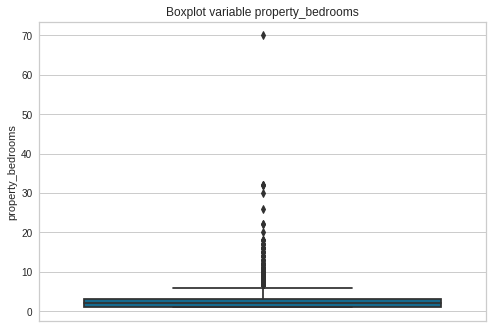

In [895]:
sns.boxplot(y=ds_train.property_bedrooms).set( title="Boxplot variable property_bedrooms")

A la vista podemos ver un valor que sobresale del resto por mucho, una propiedad con 70 dormitorios

Valor maximo de dormitorios antes de ser outlier

In [896]:
print("Podemos observar que el valor maximo que puede tomar un registro en la variable property_bedrooms antes de ser outlier en el grafico es: " + str(ds_rangos["max_whisker"][1])) 

Podemos observar que el valor maximo que puede tomar un registro en la variable property_bedrooms antes de ser outlier en el grafico es: 6.0


Vemos la cantidad de dormitorios que poseen las propiedades que fueron detectadas como outliers por z-score

In [897]:
ds_outliers_bedrooms.property_bedrooms.value_counts()

6.0     183
7.0      89
8.0      48
9.0      24
10.0     23
12.0     16
11.0      8
16.0      6
14.0      5
15.0      4
13.0      3
18.0      3
17.0      3
32.0      3
22.0      2
70.0      1
20.0      1
26.0      1
30.0      1
Name: property_bedrooms, dtype: int64

Vemos que los outliers detectados por el meotodo z-score tienen 6 o mas habitaciones, coincidente con el grafico Boxplot

In [898]:
print("Detectamos un total de: " + str(ds_outliers_bedrooms.shape[0]) + " outliers en la variable property_bedrooms")

Detectamos un total de: 424 outliers en la variable property_bedrooms


#### Analizamos property_surface_total


In [899]:
ds_train['z_surface_total'] = st.zscore(ds_train.property_surface_total)

ds_test['z_surface_total'] = st.zscore(ds_test.property_surface_total)

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers


In [900]:
ds_outliers_surface_total = ds_train[ds_train['z_surface_total'] > umbral ]
ds_outliers_surface_total.head()

latitud   longitud      place_l3 property_type  property_rooms  \
370919 -34.571747 -58.422612       Palermo  Departamento             5.0   
370921 -34.571747 -58.422612       Palermo  Departamento             5.0   
459842 -34.628397 -58.437706     Caballito  Departamento             3.0   
84073  -34.588175 -58.396261      Recoleta  Departamento             1.0   
106598 -34.587320 -58.401556  Barrio Norte  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
370919                4.0                 42110.0                     307.0   
370921                4.0                 42110.0                     307.0   
459842                2.0                  8136.0                    6472.0   
84073                 1.0                 36000.0                      30.0   
106598                1.0                 56740.0                   52540.0   

        property_price   z_rooms  z_bedrooms  z_surface_total  
370919       3044250.0  1.524414    1.852615        31.109466  
370921       2890500.0  1.524414    1.852615        31.109466  
459842        203550.0  0.120207    0.079971         5.942082  
84073          90000.0 -1.284000   -0.806350        26.583278  
106598        175000.0 -0.581897   -0.806350        41.947131

Verificamos si hay algun valor tal que z < -3

In [901]:
ds_train[ds_train['z_surface_total'] < -umbral ]

Empty DataFrame
Columns: [latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, z_bedrooms, z_surface_total]
Index: []

Grafico


[Text(0.5, 1.0, 'Boxplot variable property_surface_total')]

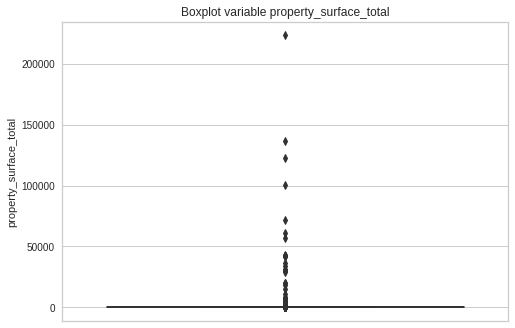

In [902]:
sns.boxplot(y=ds_train.property_surface_total).set( title="Boxplot variable property_surface_total")

Vemos como casi lo unico que se observa en el grafico son valores atipicos, esto sucede dado a que hay outliers con valores muy elevados, como por ejemplo la propiedad con una superficie total de 200000 metros cuadrados

Busco valor minimo y maximo de los outliers

In [903]:
print("Valor maximo de los outliers en la variable property_surface_total es: " + str(ds_outliers_surface_total.property_surface_total.max()))
print("Valor minimo de los outliers en la variable property_surface_total es: " + str(ds_outliers_surface_total.property_surface_total.min()))

Valor maximo de los outliers en la variable property_surface_total es: 223402.59621687402
Valor minimo de los outliers en la variable property_surface_total es: 4224.0


Cantidad de outliers 

In [904]:
print("La cantidad de outliers detectados en la variable property_surface_total es: " + str(ds_outliers_surface_total.shape[0]))

La cantidad de outliers detectados en la variable property_surface_total es: 42


#### Analizamos property_surface_covered


In [905]:
ds_train['z_surface_covered']=st.zscore(ds_train.property_surface_covered)

ds_test['z_surface_covered']=st.zscore(ds_test.property_surface_covered)

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers


In [906]:
ds_outliers_surface_covered = ds_train[ds_train['z_surface_covered'] > umbral ]
ds_outliers_surface_covered.head()

latitud   longitud      place_l3 property_type  property_rooms  \
459842 -34.628397 -58.437706     Caballito  Departamento             3.0   
106598 -34.587320 -58.401556  Barrio Norte  Departamento             2.0   
459847 -34.628247 -58.437696     Caballito  Departamento             4.0   
352883 -34.550093 -58.483034      Saavedra  Departamento             1.0   
293109 -34.603310 -58.419520       Almagro  Departamento             3.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
459842                2.0                  8136.0               6472.000000   
106598                1.0                 56740.0              52540.000000   
459847                3.0                 18096.0               8568.000000   
352883                1.0                 29064.0              29064.000000   
293109                2.0                  5239.0               3377.316631   

        property_price   z_rooms  z_bedrooms  z_surface_total  \
459842        203550.0  0.120207    0.079971         5.942082   
106598        175000.0 -0.581897   -0.806350        41.947131   
459847        324558.0  0.822310    0.966293        13.320287   
352883         87400.0 -1.284000   -0.806350        21.445202   
293109        119000.0  0.120207    0.079971         3.796031   

        z_surface_covered  
459842           5.986532  
106598          49.187311  
459847           7.952079  
352883          27.172431  
293109           3.084458

Grafico


[Text(0.5, 1.0, 'Boxplot variable property_surface_covered')]

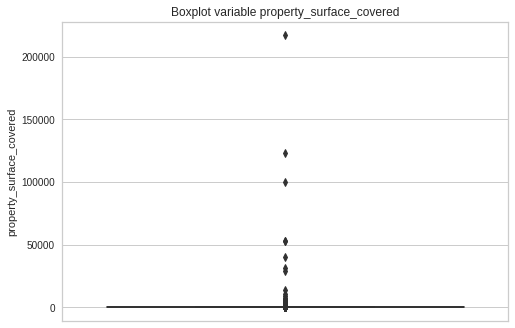

In [907]:
sns.boxplot(y=ds_train.property_surface_covered).set( title="Boxplot variable property_surface_covered")

Al igual que el grafico de surface_total, los outliers tienen valores tan grandes que es casi lo unico que se ve en el grafico. Por ejemplo ese valor atipico de valor mayor a 200.000

Buscamos valores maximos y minimos de los outliers

In [908]:
print("Valor maximo de los outliers en la variable property_surface_covered es: " + str(ds_outliers_surface_covered.property_surface_covered.max()))
print("Valor minimo de los outliers en la variable property_surface_covered es: " + str(ds_outliers_surface_covered.property_surface_covered.min()))

Valor maximo de los outliers en la variable property_surface_covered es: 217000.0
Valor minimo de los outliers en la variable property_surface_covered es: 3367.0


Calculamos la cantidad de outliers detectados

In [909]:
print("La cantidad de outliers detectados en la variable property_surface_covered es: " + str(ds_outliers_surface_covered.shape[0]))

La cantidad de outliers detectados en la variable property_surface_covered es: 23


#### Analizamos property_price


In [910]:
ds_train['z_price']=st.zscore(ds_train.property_price)
ds_test['z_price']=st.zscore(ds_test.property_price)

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers


In [911]:
ds_outliers_price = ds_train[ds_train['z_price'] > umbral ]
ds_outliers_price.head()

latitud   longitud       place_l3 property_type  property_rooms  \
210381 -34.614981 -58.362643  Puerto Madero  Departamento             6.0   
224133 -34.568032 -58.441285       Belgrano          Casa             6.0   
229380 -34.611244 -58.360546  Puerto Madero  Departamento             4.0   
301217 -34.613289 -58.362148  Puerto Madero  Departamento             3.0   
275653 -34.603362 -58.364035  Puerto Madero  Departamento             4.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
210381                5.0                   500.0                     470.0   
224133                5.0                   550.0                     550.0   
229380                2.0                   220.0                     220.0   
301217                2.0                   466.0                     319.0   
275653                3.0                   346.0                     328.0   

        property_price   z_rooms  z_bedrooms  z_surface_total  \
210381       2950000.0  2.226517    2.738936         0.285458   
224133       1580000.0  2.226517    2.738936         0.322497   
229380       1680000.0  0.822310    0.079971         0.078038   
301217       3000000.0  0.120207    0.079971         0.260271   
275653       2000000.0  0.822310    0.966293         0.171377   

        z_surface_covered   z_price  
210381           0.358090  8.515923  
224133           0.433111  4.235780  
229380           0.123650  4.548199  
301217           0.216488  8.672133  
275653           0.224928  5.547941

Verificamos si hay algun valor tal que z < -3

In [912]:
ds_outliers_price = ds_train[ds_train['z_price'] < -umbral ]

Grafico


[Text(0.5, 1.0, 'Boxplot variable property_price')]

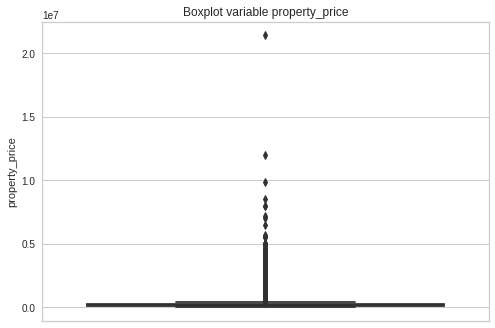

In [913]:
sns.boxplot(y=ds_train.property_price).set( title="Boxplot variable property_price")

Valor maximo en el grafico antes de ser outlier

In [914]:
print("Podemos observar que el valor maximo que puede tomar un registro en la variable property_rooms antes de ser outlier en el grafico es: " + str(ds_rangos["max_whisker"][4]))

Podemos observar que el valor maximo que puede tomar un registro en la variable property_rooms antes de ser outlier en el grafico es: 445000.0


Vemos la cantidad de outliers detectados con z-score property_price

In [915]:
print("Detectamos un total de: " + str(ds_outliers_price.shape[0]) + " outliers en la variable property_price")

Detectamos un total de: 0 outliers en la variable property_price


Valor maximo y minimo de los outliers

In [916]:
print("Valor maximo de los outliers en la variable property_price es: " + str(ds_outliers_price.property_price.max()))
print("Valor minimo de los outliers en la variable property_price es: " + str(ds_outliers_price.property_price.min()))

Valor maximo de los outliers en la variable property_price es: nan
Valor minimo de los outliers en la variable property_price es: nan


### Detectar valores atípicos en los datos en forma multivariada


Guardo los datasets con las columnas que agregamos en el punto anterior y elimino dichas columnas del dataset de train y test

In [917]:
#perservo datasets con columnas z_score
ds_train_zscore = ds_train.copy()
ds_test_zscore = ds_test.copy()

#elimino de los datasets originales las columnas anadidas
columnas_zscore = ["z_rooms", "z_bedrooms", "z_surface_total", "z_surface_covered", "z_price"]

ds_train.drop(columns = columnas_zscore, inplace=True)
ds_test.drop(columns = columnas_zscore, inplace=True)

Preparo dataset para isolation forest

In [918]:
columnas_isolationforest_a_eliminar = ["place_l3", "latitud", "longitud"]

ds_train_iforest = ds_train.drop(columns = columnas_isolationforest_a_eliminar)
ds_test_iforest = ds_test.drop(columns = columnas_isolationforest_a_eliminar)


Dummies para columna property_type

In [919]:
ds_train_iforest = pd.get_dummies(ds_train_iforest, columns=['property_type'])
ds_test_iforest = pd.get_dummies(ds_test_iforest, columns=['property_type'])

In [920]:
ds_train_iforest.head()

property_rooms  property_bedrooms  property_surface_total  \
280087             2.0                1.0                    53.0   
256350             2.0                1.0                    35.0   
135168             1.0                1.0                    25.0   
227831             5.0                3.0                    75.0   
409101             2.0                1.0                    46.0   

        property_surface_covered  property_price  property_type_Casa  \
280087                      49.0         80000.0                   0   
256350                      35.0         79900.0                   0   
135168                      20.0         69000.0                   0   
227831                      75.0        150000.0                   0   
409101                      34.0         85000.0                   0   

        property_type_Departamento  property_type_PH  
280087                           1                 0  
256350                           1                 0  
135168                           1                 0  
227831                           1                 0  
409101                           1                 0

Utilizamos el metodo de Isolation Forest


In [921]:
from sklearn.ensemble import IsolationForest
#Creo el modelo
iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=8, 
                          bootstrap=False, n_jobs=-1, random_state=1)

Entreno y genero la predicción


In [922]:
pred_train = iforest.fit_predict(ds_train_iforest)
pred_test  = iforest.predict(ds_test_iforest)

/home/fanu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Cargo las etiquetas a los datasets

In [923]:
ds_train_iforest['scores']=iforest.decision_function(ds_train_iforest)
ds_train_iforest['outlier_label'] = pred_train

ds_test_iforest['scores']=iforest.decision_function(ds_test_iforest)
ds_test_iforest['outlier_label'] = pred_test

Los registros etiquetados con "-1" son considerados como outliers

In [924]:
ds_train_iforest[ds_train_iforest.outlier_label == -1].head()

property_rooms  property_bedrooms  property_surface_total  \
210381             6.0                5.0                   500.0   
413132             5.0                3.0                   290.0   
401702             7.0                5.0                   624.0   
9661              12.0                5.0                   435.0   
224133             6.0                5.0                   550.0   

        property_surface_covered  property_price  property_type_Casa  \
210381                     470.0       2950000.0                   0   
413132                     230.0        815000.0                   1   
401702                     624.0       1111111.0                   0   
9661                       435.0        850000.0                   0   
224133                     550.0       1580000.0                   1   

        property_type_Departamento  property_type_PH    scores  outlier_label  
210381                           1                 0 -0.126863             -1  
413132                           0                 0 -0.016503             -1  
401702                           1                 0 -0.108906             -1  
9661                             1                 0 -0.110981             -1  
224133                           0                 0 -0.125177             -1

In [925]:
#guardo indices de outliers para mas adelante
indice_outliers_iforest_train = ds_train_iforest[ds_train_iforest.outlier_label == -1].index.to_list()

Cuento la cantidad de observaciones anomalas


In [926]:
cant_outliers_train = ds_train_iforest.outlier_label.value_counts().to_frame().outlier_label[-1]
cant_outliers_test = ds_test_iforest.outlier_label.value_counts().to_frame().outlier_label[-1]

print("La cantidad de outliers detectados en el dataset de train es: " + str(cant_outliers_train))
print("La cantidad de outliers detectados en el dataset de test es: " + str(cant_outliers_test))

La cantidad de outliers detectados en el dataset de train es: 3612
La cantidad de outliers detectados en el dataset de test es: 914


Visualizamos uno de los clasificadores de los 100 estimadores que elegimos, para ver como clasifica

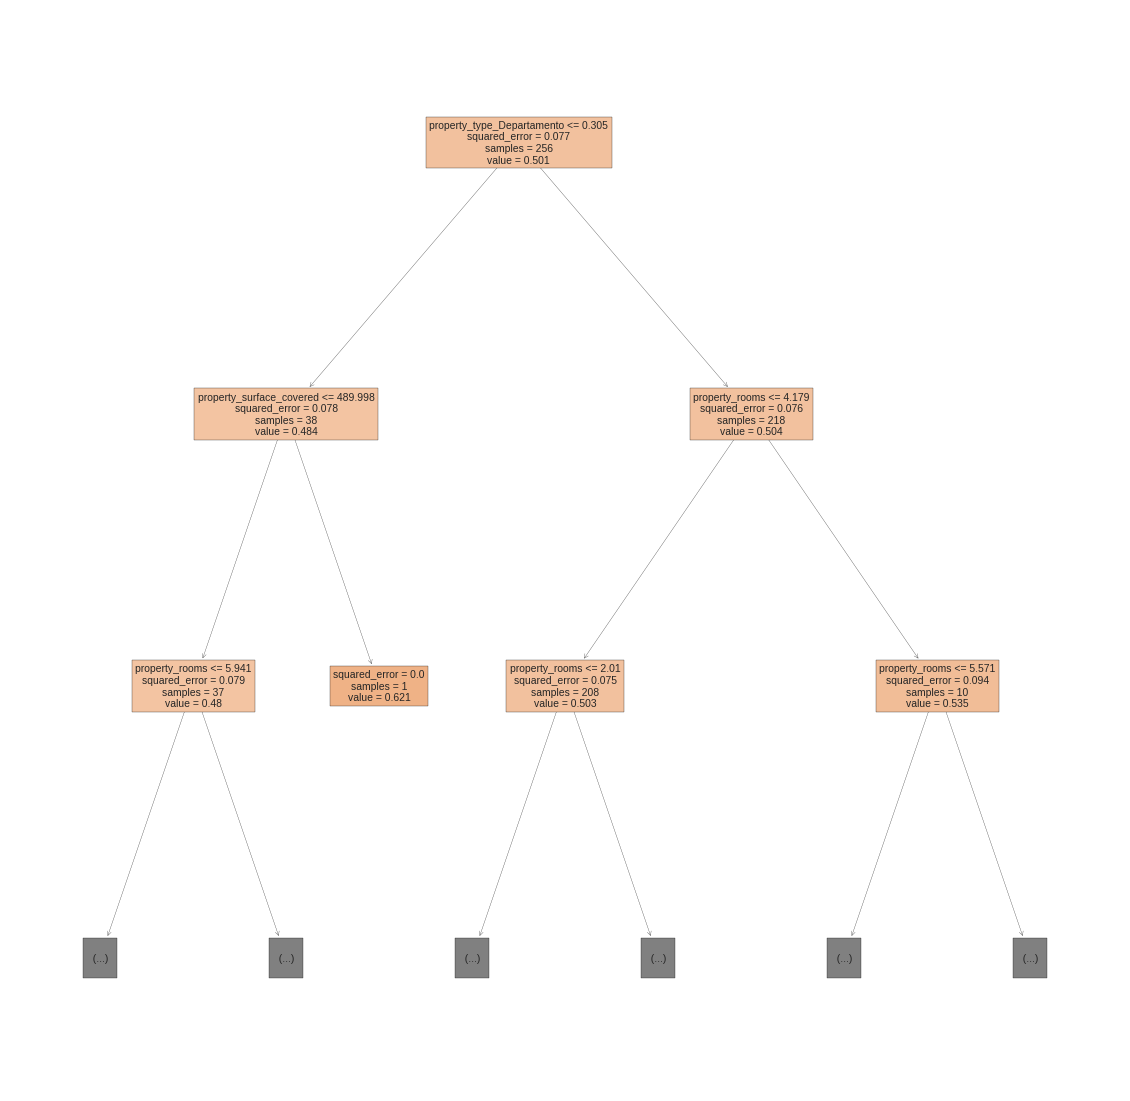

In [927]:
#Selecciono el árbol
estimator = iforest.estimators_[5]

#Grafico
plt.figure(figsize=(20,20))
sk.tree.plot_tree(estimator,feature_names=ds_train_iforest.columns,filled=True,max_depth=2)
plt.show()

Ver como en el nodo del segundo renglon a la derecha, se puede observar como si la propiedad tiene mas de 8 habitaciones, puede ser aislado tempranamente y clasificado como outlier #### seguir esto

#### Graficos de valores atipicos relacionando las columnas del dataset


#### property_price vs property_rooms


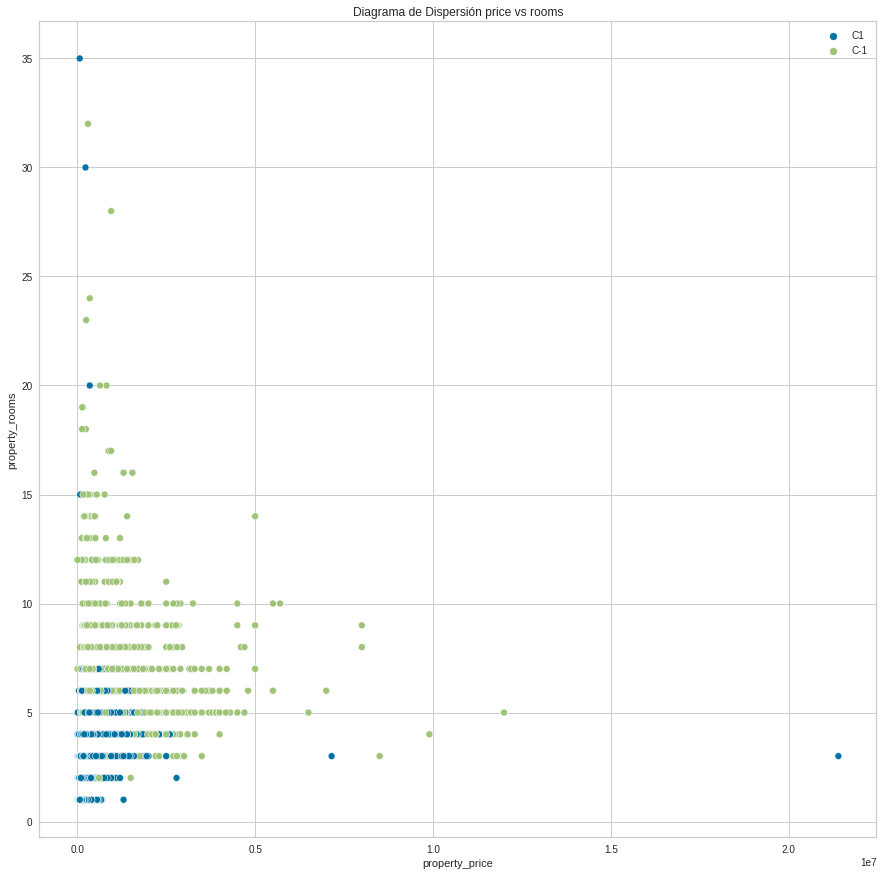

In [928]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_train_iforest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_train_iforest['property_price'],y=ds_train_iforest['property_rooms'],hue=color)
plt.title('Diagrama de Dispersión price vs rooms')
plt.show()

Podemos observar que la mayor densidad de outliers (puntos naranja) se encuentran en donde una propiedad tiene muchas habitaciones (mas de 7). Con respecto a los valores normales, se puede observar que la mayoria esta dentro de un rango de 5 habitaciones y con un precio relativamente bajo.

#### property_bedrooms vs property_rooms


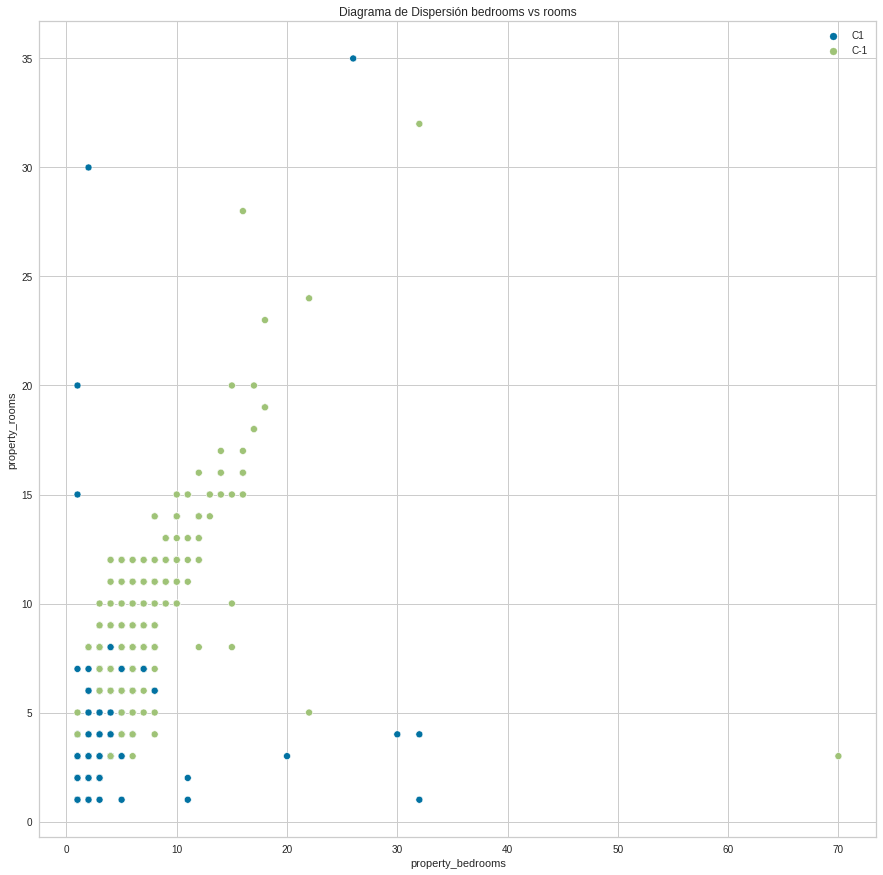

In [929]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_train_iforest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_train_iforest['property_bedrooms'],y=ds_train_iforest['property_rooms'],hue=color)
plt.title('Diagrama de Dispersión bedrooms vs rooms')
plt.show()

Se puede observar una correlacion positiva respecto a estas variables, como analizamos anteriormente.  
Observamos muchos outliers con habitaciones y dormitorios de mas de 6 unidades, los valores considerados outliers estan mas bien en la parte "baja" del grafico.
Notamos par de excepciones, como las prpiedades que tienen 30/35 dormitorios y 5 habitaciones, como tambien, 15 habitaciones y 3 dormitorios 

#### property_price vs property_surface_covered


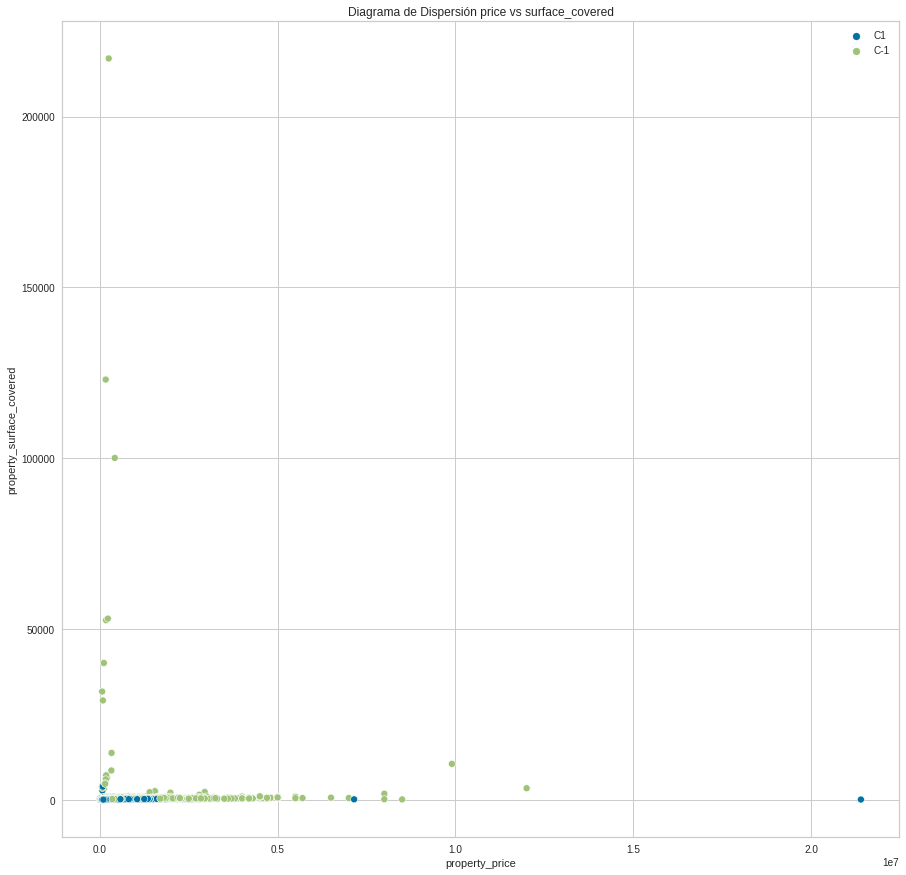

In [930]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_train_iforest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_train_iforest['property_price'],y=ds_train_iforest['property_surface_covered'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_covered')
plt.show()

#### property_price vs property_surface_total


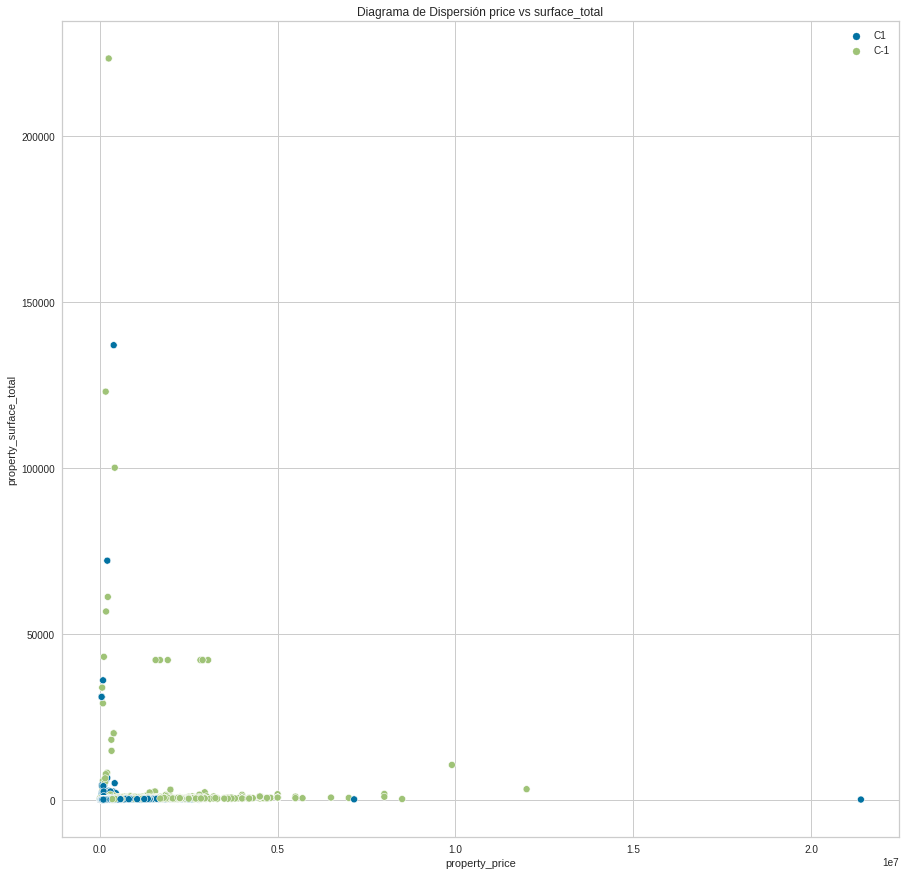

In [931]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_train_iforest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_train_iforest['property_price'],y=ds_train_iforest['property_surface_total'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_total')
plt.show()

#### property_price vs property_surface_covered

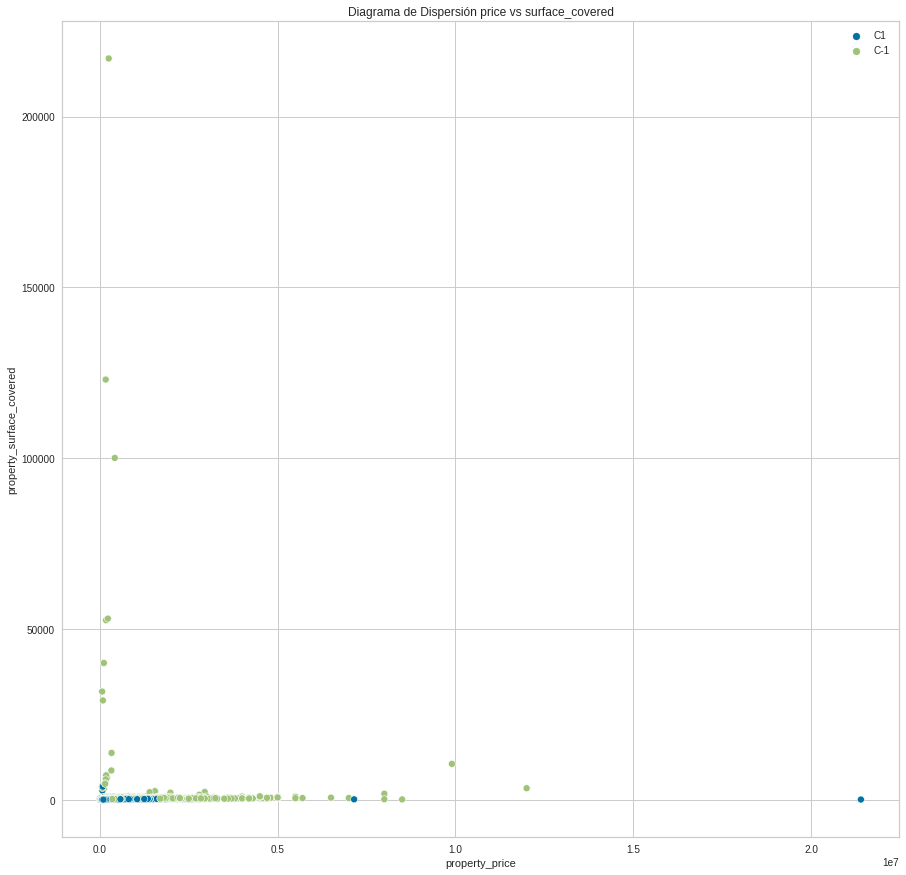

In [932]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_train_iforest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_train_iforest['property_price'],y=ds_train_iforest['property_surface_covered'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_covered')
plt.show()

#### property_surface_total vs property_suface_covered

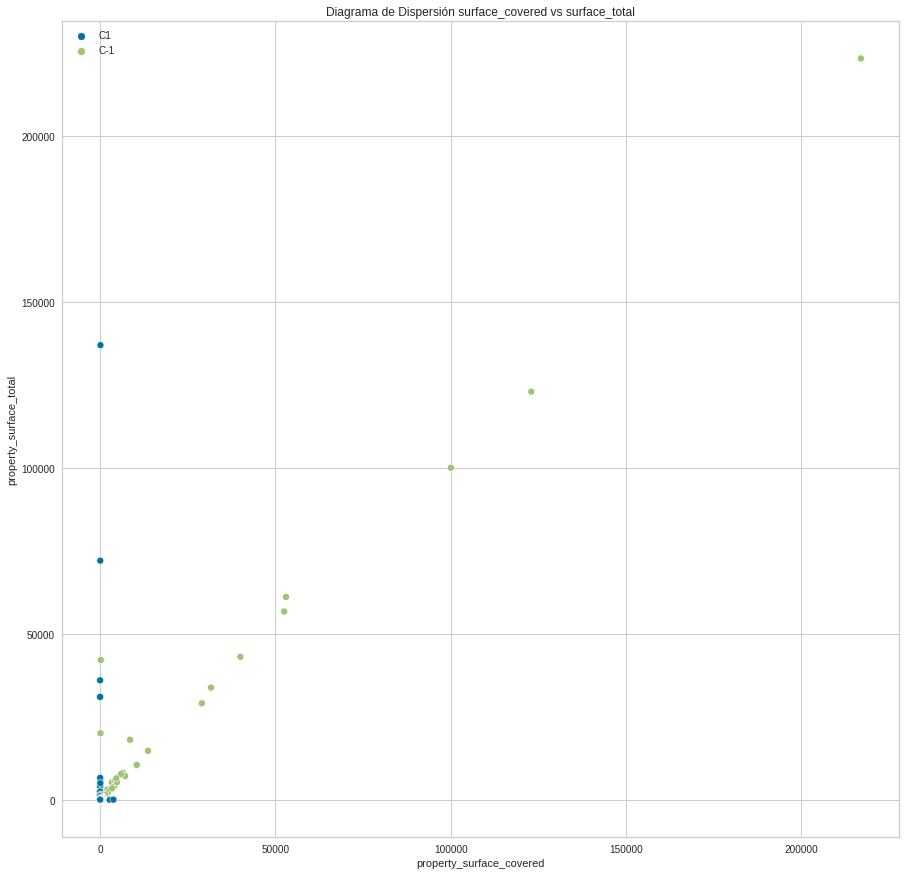

In [933]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_train_iforest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_train_iforest['property_surface_covered'],y=ds_train_iforest['property_surface_total'],hue=color)
plt.title('Diagrama de Dispersión surface_covered vs surface_total')
plt.show()

### Caracterisicas de los datos atipicos detectados

- Los datos atipicos encontrados de forma univariada tienen la caracteristica que tiene tres o mas desviaciones estándar de la media muestral 
- Los datos atipicos detectados de forma multivariada, tienen la caracteristica de ser un valor extremo, pero cuando se lo considera con otra variable, por ejemplo si un departamento tiene un precio extremadamente alto y solo 1 habitacion, o en el caso contrario, de ser un departamento de 10 habitaciones con un precio muy bajo.

### Características y tratamientos de los datos atípicos detectados.


Con los analisis univariados y multivariados que analizamos, concluimos que la mayoria de los datos atipicos los encontramos en valores relacionados con las variables "property_bedrooms", "property_rooms" y "property_price".

Luego de los distintos análisis del dataset pudimos obvservar que al aplicar el método univariado encontramos aquellos outliers con valores extremos en relación a cada columna en particular. En cambio, al implementar el modelo de Isolation Forest para valores atípicos multivariados obtuvimos otras muestras a tener en cuenta como outliers para un mejor tratamiento de los mismos.

Decidimos eliminar aquellos valores atipicos que encontramos en ambos metodos, univariado y multivariado, esta decision la tomamos debido a que la cantidad de registros detectados como outliers no es un numero significativo para dañar el analisis sobre el mismo.

Eliminacion de valores atipicos coincidentes en ambos metodos


verifico tamano de los datasets train test pre depuracion 

In [934]:
print("Tamanio dataset ds_train pre depuracion: " + str(ds_train.shape))
print("Tamanio dataset ds_test pre depuracion: " + str(ds_test.shape))

Tamanio dataset ds_train pre depuracion: (72239, 9)
Tamanio dataset ds_test pre depuracion: (18084, 9)


In [935]:
from collections import OrderedDict
from iteration_utilities import duplicates # hay que instalar iteration_utilities "pip install iteration_utilities"
from iteration_utilities import unique_everseen

def eliminacion_outliers(dataset_zscore, dataset_iforest, dataset_a_depurar):

    #obtencion indices outliers univariados
    indice_price = dataset_zscore[dataset_zscore['z_price'] > 3 ].index.to_list()
    indice_bedrooms = dataset_zscore[dataset_zscore['z_bedrooms'] > 3 ].index.to_list()
    indice_rooms = dataset_zscore[dataset_zscore['z_rooms'] > 3 ].index.to_list()
    indice_surface_covered = dataset_zscore[dataset_zscore['z_surface_covered'] > 3 ].index.to_list()
    indice_surface_total = dataset_zscore[dataset_zscore['z_surface_total'] > 3 ].index.to_list()

    #obtencion indices outliers multivariados
    indice_multi_variable = dataset_iforest[dataset_iforest.outlier_label==-1].index.to_list()

    #indices coicidentes
    #indices_a_eliminar = indice_price + indice_bedrooms + indice_rooms + indice_surface_covered + indice_surface_total
    #indices_a_eliminar = list(OrderedDict.fromkeys(indices_a_eliminar))
    #indices_a_eliminar = indices_a_eliminar + indice_multi_variable
    #indices_a_eliminar = list(unique_everseen(duplicates(indices_a_eliminar)))

    #ELimino ambos, detectados uni y multivariados
    indices_a_eliminar = indice_price + indice_bedrooms + indice_rooms + indice_surface_covered + indice_surface_total
    indices_a_eliminar = indices_a_eliminar + indice_multi_variable
    indices_a_eliminar = set(indices_a_eliminar)
    print("cantidad de elementos a eliminar: " + str(len(indices_a_eliminar)))

    #eliminacion dataset
    dataset_a_depurar.drop(index = indices_a_eliminar, inplace = True)
    return indices_a_eliminar

indices_a_eliminar_train = eliminacion_outliers(ds_train_zscore, ds_train_iforest, ds_train)
indices_a_eliminar_test = eliminacion_outliers(ds_test_zscore, ds_test_iforest, ds_test)

cantidad de elementos a eliminar: 4052
cantidad de elementos a eliminar: 1042


verifico tamano de los datasets train test post depuracion 

In [936]:
print("Tamanio dataset ds_train post depuracion: " + str(ds_train.shape))
print("Tamanio dataset ds_test post depuracion: " + str(ds_test.shape))

Tamanio dataset ds_train post depuracion: (68187, 9)
Tamanio dataset ds_test post depuracion: (17042, 9)


### Analizar la relación entre el precio de venta y los metros de superficie


volvemos a hacer el analisis despues de la depuracion


In [937]:
iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=8, 
                          bootstrap=False, n_jobs=-1, random_state=1)

Preparo datasets para isolation forest

In [938]:
columnas_isolationforest_a_eliminar = ["place_l3", "latitud", "longitud"]

ds_train_iforest2 = ds_train.drop(columns = columnas_isolationforest_a_eliminar)
ds_test_iforest2 = ds_test.drop(columns = columnas_isolationforest_a_eliminar)

aplico Dummies a la variable property_type

In [939]:
ds_train_iforest2 = pd.get_dummies(ds_train_iforest2, columns=['property_type'])

Entreno y genero la predicción


In [940]:
pred = iforest.fit_predict(ds_train_iforest2)

/home/fanu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [941]:
ds_train_iforest2['scores'] = iforest.decision_function(ds_train_iforest2)
ds_train_iforest2['outlier_label'] = pred

Los registros etiquetados con "-1" son considerados como outliers

In [942]:
ds_train_iforest2[ds_train_iforest2.outlier_label==-1]

property_rooms  property_bedrooms  property_surface_total  \
270830             4.0                3.0              128.000000   
354298             5.0                4.0              254.000000   
251584             5.0                3.0              173.000000   
349977             5.0                4.0              270.000000   
106900             4.0                2.0              210.000000   
...                ...                ...                     ...   
378675             4.0                3.0              178.000000   
374238             4.0                3.0              218.708922   
407577             5.0                3.0              143.000000   
416301             4.0                3.0              168.000000   
38899              5.0                3.0              168.000000   

        property_surface_covered  property_price  property_type_Casa  \
270830                     128.0        183000.0                   1   
354298                     245.0        750000.0                   0   
251584                     153.0        320000.0                   0   
349977                     265.0        669000.0                   0   
106900                     201.0        790000.0                   0   
...                          ...             ...                 ...   
378675                     127.0        235000.0                   1   
374238                     175.0        185000.0                   0   
407577                     143.0        205000.0                   1   
416301                     147.0        390000.0                   0   
38899                      120.0        340000.0                   1   

        property_type_Departamento  property_type_PH    scores  outlier_label  
270830                           0                 0 -0.040491             -1  
354298                           1                 0 -0.047076             -1  
251584                           0                 1 -0.020098             -1  
349977                           1                 0 -0.056427             -1  
106900                           1                 0 -0.016721             -1  
...                            ...               ...       ...            ...  
378675                           0                 0 -0.048604             -1  
374238                           0                 1 -0.010244             -1  
407577                           0                 0 -0.065130             -1  
416301                           0                 1 -0.003297             -1  
38899                            0                 0 -0.066873             -1  

[3410 rows x 10 columns]

cantidad de obs. anómalas


In [943]:
ds_train_iforest2.outlier_label.value_counts()

 1    64777
-1     3410
Name: outlier_label, dtype: int64

In [944]:
outliers_detectados = ds_train_iforest2.outlier_label.value_counts()[-1]
print("Se detectaron " + str(outliers_detectados) + " outliers")

Se detectaron 3410 outliers


Me fijo cuantos de estos outliers ya fueron detectados previamente

In [945]:
indices_outliers_iforest2 = ds_train_iforest2[ds_train_iforest2.outlier_label==-1].index.to_list()

def contar_coincidentes():
    cant_repetidos = 0
    for indice in indice_outliers_iforest_train:
        if(indice in indices_outliers_iforest2):
            cant_repetidos += 1
    return cant_repetidos

repetidos = contar_coincidentes()
cant_nuevos_outliers = outliers_detectados - repetidos

In [946]:
print("En total se detectaron "  + str(cant_nuevos_outliers) + " nuevos outliers")

En total se detectaron 3410 nuevos outliers


Los outliers en casos multivariados como los que analizamos previamente, pueden provocar un efecto de enmascaramietno que se produce cuando un grupo de outliers esconden a otros. Es decir, los outliers enmascarados se haran visibles cuando se eliminen los outliers que los esconden.
En nuestro caso, observamos como al eliminar la primer tanda de valores atipicos y realizar el analisis nuevamente, encontramos nuevos outliers.


Grafico dispersograma


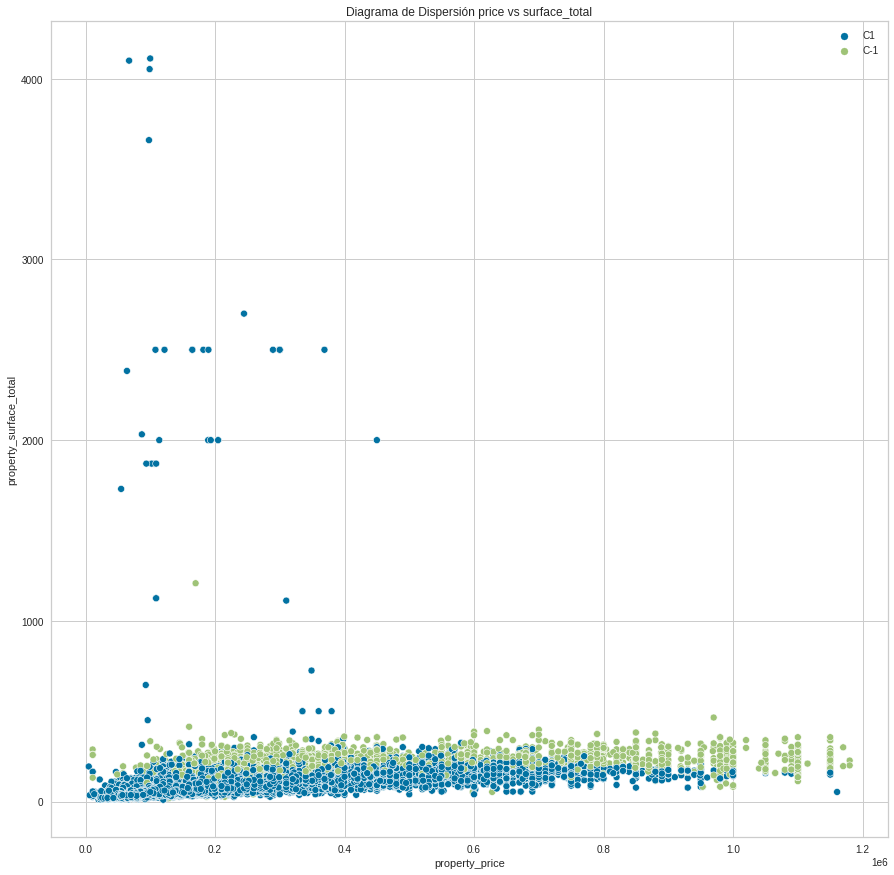

In [947]:
color=[f"C{n}" for n in (ds_train_iforest2['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_train_iforest2['property_price'],y=ds_train_iforest2['property_surface_total'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_total')
plt.show()

 - Vemos como a medida que nos movemos en el eje del precio hacia la derecha y nos mantenemos constante en el eje de la superficie, la cantidad de outliers aumenta considerablemente
 - Dado que analizamos los valores atipicos de forma multivariada, las observaciones suelen estar en un rango normal si las observamos por separado, pero al momento de analizarlas con otras variables, pueden llegar a ser consideradas como outliers.  

Analizamos algunas caracteristicas de los valores atipicos detectados

In [948]:
#persisto train y test 
#ds_train.to_csv("properati_argentina_train.csv")
#ds_test.to_csv("properati_argentina_test.csv")

## Reduccion De La Dimensionalidad


Decidimos utilizar PCA para reducir la dimensionalidad del dataset

In [1083]:
#Creamos el dataset que será utilizado para la reducción y uliminamos todas las filas con columnas vacías
ds_reducido_train = ds_train.copy()
ds_reducido_test = ds_test.copy()

Preparamos dataset

In [1084]:
columnas_a_elimianar = ["place_l3"]

ds_reducido_train.drop(columns=columnas_a_elimianar, inplace=True)
ds_reducido_test.drop(columns=columnas_a_elimianar, inplace=True)

Decidimos eliminar la columna place_l3 por la cantidade de valores posibles de esta variable. No seria eficiente entrenar un algoritmo con tantas columnas

In [1085]:
ds_reducido_train = pd.get_dummies(ds_reducido_train, columns=['property_type'])
ds_reducido_test = pd.get_dummies(ds_reducido_test, columns=['property_type'])

In [1069]:
ds_reducido_train.head()

latitud   longitud  property_rooms  property_bedrooms  \
280087 -34.601807 -58.469965             2.0                1.0   
256350 -34.580088 -58.424965             2.0                1.0   
135168 -34.551481 -58.452358             1.0                1.0   
227831 -34.632290 -58.464844             5.0                3.0   
409101 -34.549279 -58.463074             2.0                1.0   

        property_surface_total  property_surface_covered  property_price  \
280087                    53.0                      49.0         80000.0   
256350                    35.0                      35.0         79900.0   
135168                    25.0                      20.0         69000.0   
227831                    75.0                      75.0        150000.0   
409101                    46.0                      34.0         85000.0   

        property_type_Casa  property_type_Departamento  property_type_PH  
280087                   0                           1                 0  
256350                   0                           1                 0  
135168                   0                           1                 0  
227831                   0                           1                 0  
409101                   0                           1                 0

Hacemos PCA para analizar posibles reducciones


In [1086]:
ds_reducido_train.drop(columns=["property_price"], inplace=True)

sc = StandardScaler()
x = ds_reducido_train.values
x = sc.fit_transform(x)

pca = PCA(n_components=9) 
x_transformada = pca.fit_transform(x)

pca_df_aux = pd.DataFrame(data = x_transformada
             , columns = ['cp_1', 'cp_2','cp_3','cp_4', 'cp_5', 'cp_6','cp_7','cp_8', 'cp_9'])


print("Variabilidad explicada por cada componente:"  + str(pca.explained_variance_ratio_))

Variabilidad explicada por cada componente:[3.71836616e-01 2.08386178e-01 1.28798173e-01 1.11547834e-01
 7.75225796e-02 6.62187802e-02 2.70373812e-02 8.65245788e-03
 3.86858961e-33]


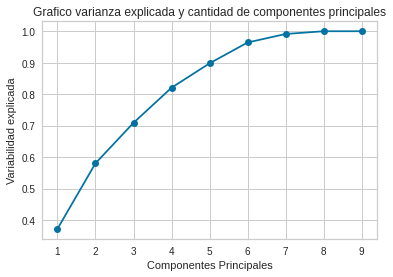

In [1087]:
variabilidad_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(variabilidad_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(6, 4))
plt.plot(list_x, variabilidad_explicada.cumsum(), '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.title("Grafico varianza explicada y cantidad de componentes principales")
plt.show()

Obtenemos la suma de la variabilidad explicada de las componentes

In [1088]:
varianza_explicada=pca.explained_variance_ratio_
varianza_explicada.cumsum()

array([0.37183662, 0.58022279, 0.70902097, 0.8205688 , 0.89809138,
       0.96431016, 0.99134754, 1.        , 1.        ])

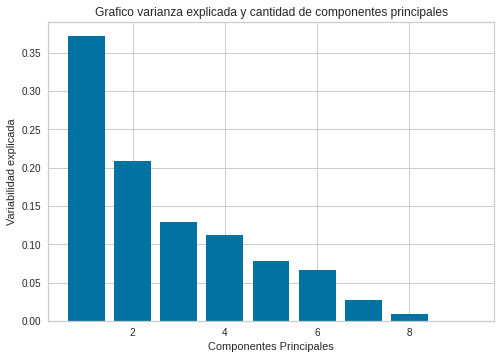

In [1089]:
list_x = list(range(1, len(variabilidad_explicada)+1))

plt.title("Grafico varianza explicada y cantidad de componentes principales")
plt.locator_params('x', nbins = 9)
plt.bar(list_x, variabilidad_explicada)
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.show()

Vemos como con 6 componentes principales podemos explicar una variabilidad de 0.96431016, y asi poder relizar una reduccion de 1 componente del dataset original.

In [1090]:
target= pd.DataFrame((np.column_stack(ds_train['property_price'])).tolist()).T
ds_reducido_train = pd.concat([pca_df_aux, target], axis = 1)
ds_reducido_train.columns= ['cp_1', 'cp_2','cp_3','cp_4', 'cp_5', 'cp_6','cp_7','cp_8', 'cp_9' ,'target']
ds_reducido_train.drop(columns = ['cp_7','cp_8', 'cp_9'], inplace=True)

In [1049]:
ds_reducido_train

cp_1      cp_2      cp_3      cp_4      cp_5      cp_6    target
0     -1.211708 -0.304701  0.416427  0.238800 -0.659845  0.328829   80000.0
1     -1.545616  0.084689  0.236823 -0.017944  0.569974 -0.187301   79900.0
2     -2.196143 -0.215823  1.530302 -0.174926  0.813270 -0.159353   69000.0
3      1.604301  0.673787 -0.646806  0.021597 -2.052820 -0.723051  150000.0
4     -1.494819 -0.002768  1.772752 -0.293147  0.571107 -0.149111   85000.0
...         ...       ...       ...       ...       ...       ...       ...
68182  0.327853  0.631039 -1.315666  0.230393 -0.474328  0.276985  175000.0
68183 -1.098109  0.006928  0.530679  0.069133  0.004538  0.267297  122000.0
68184 -1.106571  0.147672 -0.193962  0.144714  0.263654  0.349074  178000.0
68185 -1.326233  0.031527 -0.338383  0.188723  0.151968  0.142257  135000.0
68186  0.390131 -4.281723  1.087780 -1.003559  0.707554 -0.025816  100000.0

[68187 rows x 7 columns]

PCA para el test

In [1091]:
ds_reducido_test.drop(columns=["property_price"], inplace=True)

y = ds_reducido_test.values
y = sc.transform(y)


y_transformada = pca.transform(y)

pca_df_aux = pd.DataFrame(data = x_transformada
             , columns = ['cp_1', 'cp_2','cp_3','cp_4', 'cp_5', 'cp_6','cp_7','cp_8', 'cp_9'])

target= pd.DataFrame((np.column_stack(ds_test['property_price'])).tolist()).T
ds_reducido_test = pd.concat([pca_df_aux, target], axis = 1)
ds_reducido_test.columns= ['cp_1', 'cp_2','cp_3','cp_4', 'cp_5', 'cp_6','cp_7','cp_8', 'cp_9' ,'target']
ds_reducido_test.drop(columns = ['cp_7','cp_8', 'cp_9'], inplace=True)

#### Persistencia archivos


In [1092]:
ds_reducido_train.to_csv("properati_argentina_reducido_train.csv")
ds_reducido_test.to_csv("properati_argentina_reducido_test.csv")

# Agrupamiento


## Clustering


In [1004]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans

Preparo el dataset a utilizar

In [1005]:
columnas_a_elimianar = ["place_l3", "latitud", "longitud"]

ds_train_kmeans = ds_train.drop(columns = columnas_a_elimianar)
ds_test_kmeans = ds_test.drop(columns = columnas_a_elimianar)


Aplicamos dummies para property_type


In [1006]:
ds_train_kmeans = pd.get_dummies(ds_train_kmeans, columns=['property_type'])
ds_test_kmeans = pd.get_dummies(ds_test_kmeans, columns=['property_type'])

ds_train_kmeans.head()

property_rooms  property_bedrooms  property_surface_total  \
280087             2.0                1.0                    53.0   
256350             2.0                1.0                    35.0   
135168             1.0                1.0                    25.0   
227831             5.0                3.0                    75.0   
409101             2.0                1.0                    46.0   

        property_surface_covered  property_price  property_type_Casa  \
280087                      49.0         80000.0                   0   
256350                      35.0         79900.0                   0   
135168                      20.0         69000.0                   0   
227831                      75.0        150000.0                   0   
409101                      34.0         85000.0                   0   

        property_type_Departamento  property_type_PH  
280087                           1                 0  
256350                           1                 0  
135168                           1                 0  
227831                           1                 0  
409101                           1                 0

Aplicamos MinMaxScaler para variables numericas


In [1007]:
def aplicar_min_max(dataset):
    scaler = MinMaxScaler()
    dataset["property_surface_total"] = scaler.fit_transform(dataset["property_surface_total"].to_frame())
    dataset["property_surface_covered"] = scaler.fit_transform(dataset["property_surface_covered"].to_frame())
    dataset["property_price"] = scaler.fit_transform(dataset["property_price"].to_frame())
    dataset["property_bedrooms"] = scaler.fit_transform(dataset["property_bedrooms"].to_frame())
    dataset["property_rooms"] = scaler.fit_transform(dataset["property_rooms"].to_frame())

aplicar_min_max(ds_train_kmeans)


### Estimamos la cantidad apropiada de grupos que se deben formar.


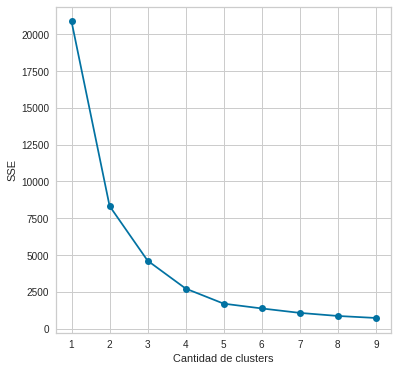

In [1008]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(ds_train_kmeans)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

Dado que no hay un numero en donde se forme un "codo" pronunciadamente, voy a usar el indice de la silueta

In [ ]:
from sklearn.metrics import silhouette_score

list_k = list(range(3, 10))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    preds = clusterer.fit_predict(ds_train_kmeans)

    score = silhouette_score (ds_train_kmeans, preds)
    print ("For n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

For n_clusters =3 silhouette score is 0.5796516322535229
For n_clusters =4 silhouette score is 0.6013943686778803
For n_clusters =5 silhouette score is 0.6097147036897348
For n_clusters =6 silhouette score is 0.5900007630102183
For n_clusters =7 silhouette score is 0.6035537608836804
For n_clusters =8 silhouette score is 0.5744408998727851
For n_clusters =9 silhouette score is 0.5841807651029673


Obtenemos un maximo local para una cantidad de 5 clusters

### k_means con 5 clusters

In [954]:
kmeans = KMeans(5, random_state=123)
kmeans.fit(ds_train_kmeans)

KMeans(n_clusters=5, random_state=123)

In [955]:
clusters = kmeans.predict(ds_train_kmeans)
ds_train_kmeans["cluster"] = clusters

In [956]:
ds_train_kmeans.head()

latitud   longitud  property_rooms  property_bedrooms  \
280087 -34.601807 -58.469965        0.166667                0.0   
256350 -34.580088 -58.424965        0.166667                0.0   
135168 -34.551481 -58.452358        0.000000                0.0   
227831 -34.632290 -58.464844        0.666667                0.5   
409101 -34.549279 -58.463074        0.166667                0.0   

        property_surface_total  property_surface_covered  property_price  \
280087                0.010483                  0.017784        0.063830   
256350                0.006095                  0.012597        0.063745   
135168                0.003657                  0.007040        0.054468   
227831                0.015846                  0.027418        0.123404   
409101                0.008776                  0.012227        0.068085   

        property_type_Casa  property_type_Departamento  property_type_PH  \
280087                   0                           1                 0   
256350                   0                           1                 0   
135168                   0                           1                 0   
227831                   0                           1                 0   
409101                   0                           1                 0   

        cluster  
280087        2  
256350        2  
135168        2  
227831        4  
409101        2

#### Siulhuete

/home/fanu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


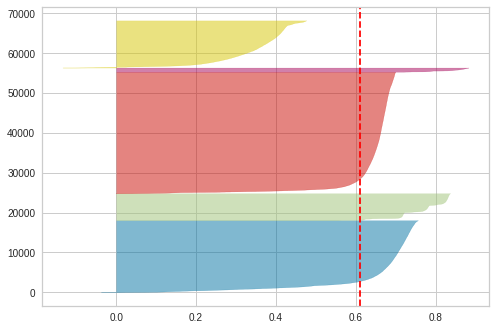

In [957]:
from yellowbrick.cluster import SilhouetteVisualizer


visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(ds_train_kmeans.drop(columns=["cluster"]))
plt.show()

Analizando el grafico podemos observar como los clusters 0 (amarillo) y 4 (azul) poseen outliers, sin bien son pocos comparados con la magnitud de los mismos cluster, es importante remarcarlo.  

#### Analisis por grupo

In [958]:
#preparo dataset para analisis, necesito los valores sin normalizar para mejor interpretacion humana

#dummies
ds_grupos = pd.get_dummies(ds_train, columns=['property_type'])

#clusters
ds_grupos["cluster"] = ds_train_kmeans["cluster"]


##### Grafico los cluster en el mapa

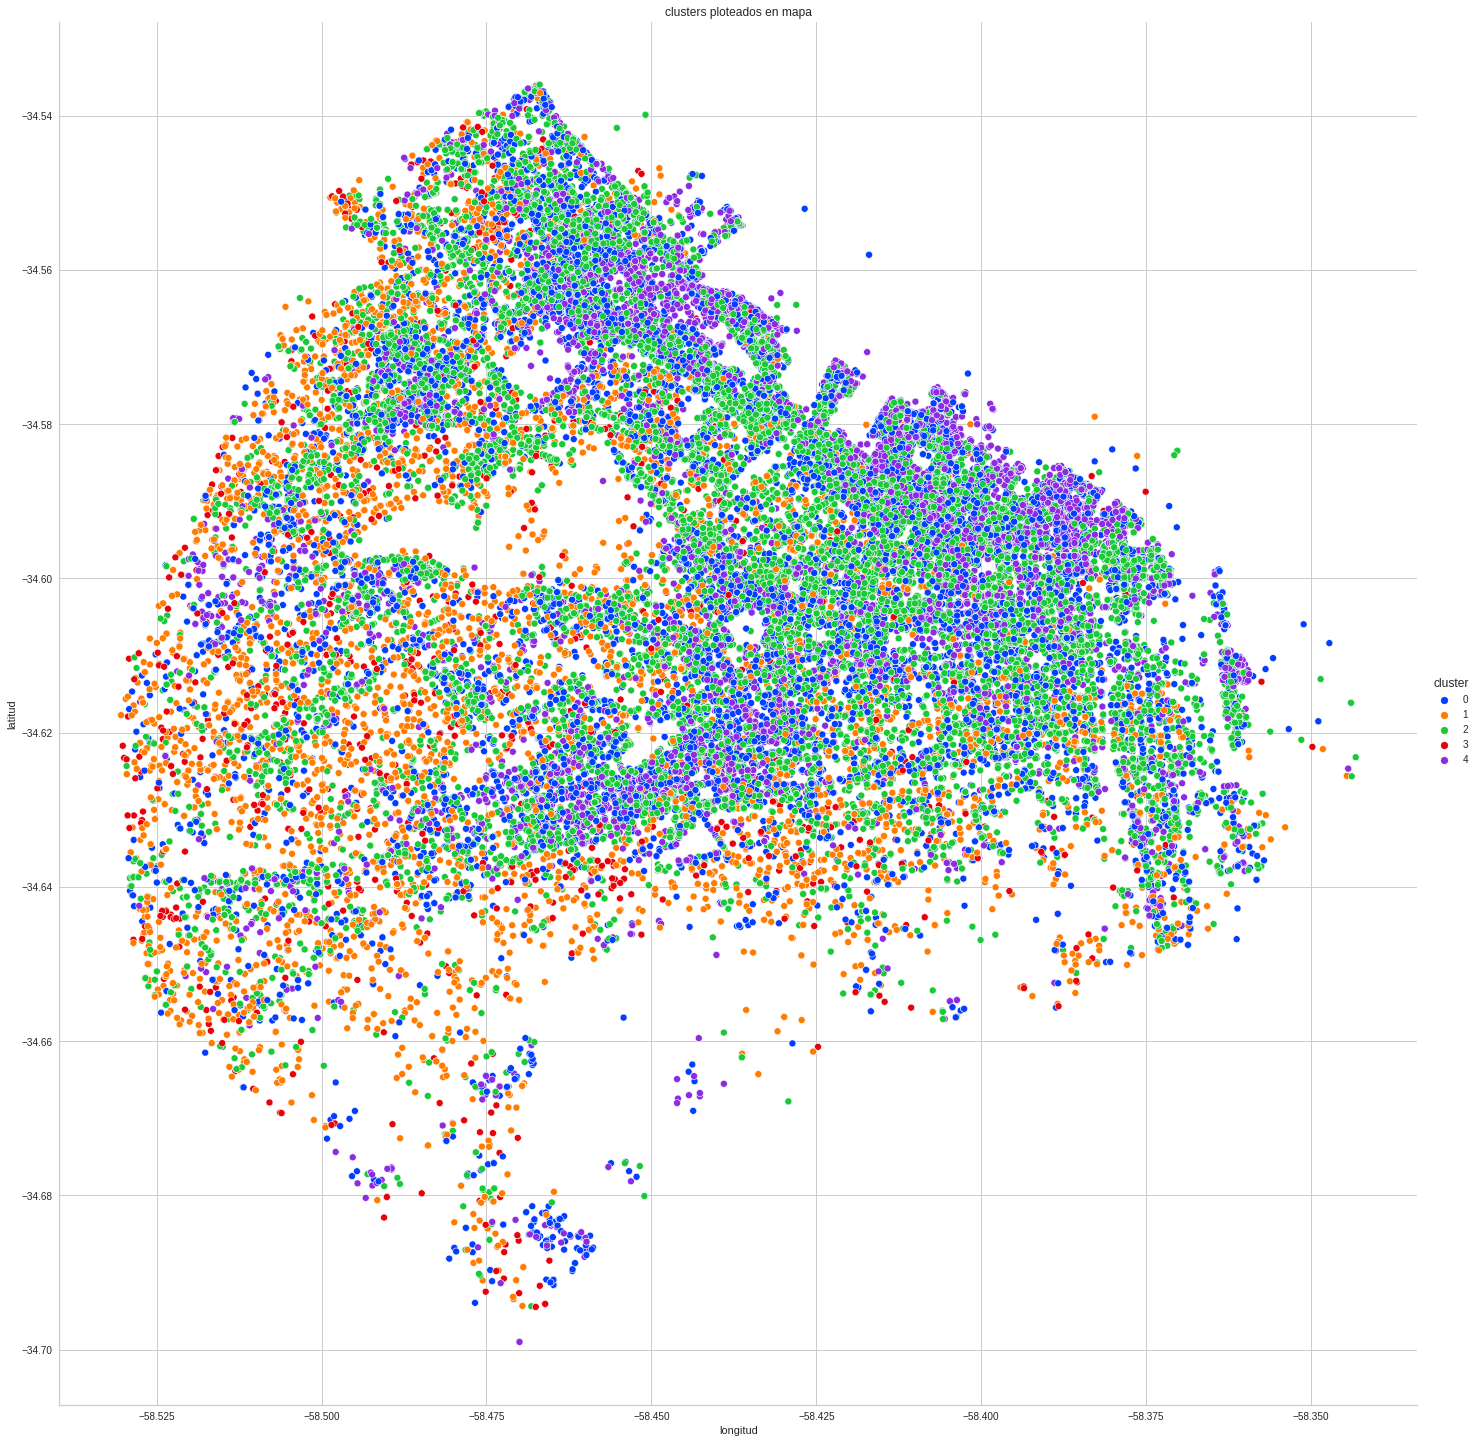

In [959]:
graf_relplot=sns.relplot(data=ds_train_kmeans,x="longitud", y="latitud", hue="cluster", palette= "bright", height=20).set(title="clusters ploteados en mapa",xlabel='longitud',ylabel='latitud')

Analizo cada cluster

##### Grupo 0

In [960]:
ds_grupo0 = ds_grupos[ds_grupos["cluster"] == 0]

In [961]:
cantidad_de_obs = ds_grupo0.shape[0]
print("La cantidad de registros en este cluster es de: " + str(cantidad_de_obs))

La cantidad de registros en este cluster es de: 18056


Tipos y cantidad de propiedades en el grupo

In [962]:
ds_grupo0[["property_type_Departamento", "property_type_Casa", "property_type_PH"]].sum()

property_type_Departamento    18056
property_type_Casa                0
property_type_PH                  0
dtype: int64

- El cluster 0, coloreado en azul se lo observa bastante distribuido por todo el mapa
- Su unico tipo de propiedad es departamento.
- si miramos cuidadosamente observamos que tiene mayor densidad de apariciones en el centro de Capital Federal

Algunos valores importantes

In [963]:
precio_promedio = ds_grupo0.property_price.mean().round()
print("El precio promedio de las propiedades es de: $" + str(precio_promedio) + " dolares")
sup_promedio = ds_grupo0.property_surface_total.mean().round()
print("El property_surface_total promedio de las propiedades es de: " + str(sup_promedio) + " metros cuadrados")
rooms_promedio = ds_grupo0.property_rooms.mean().round()
print("El property_rooms promedio de las propiedades es de: " + str(rooms_promedio) + " habitaciones")

El precio promedio de las propiedades es de: $191400.0 dolares
El property_surface_total promedio de las propiedades es de: 79.0 metros cuadrados
El property_rooms promedio de las propiedades es de: 3.0 habitaciones


##### Grupo 1

In [964]:
ds_grupo1 = ds_grupos[ds_grupos["cluster"] == 1]

In [965]:
cantidad_de_obs = ds_grupo1.shape[0]
print("La cantidad de registros en este cluster es de: " + str(cantidad_de_obs))

La cantidad de registros en este cluster es de: 6771


Tipos y cantidad de propiedades en el grupo

In [966]:
ds_grupo1[["property_type_Departamento", "property_type_Casa", "property_type_PH"]].sum()

property_type_Departamento       0
property_type_Casa               0
property_type_PH              6771
dtype: int64

- El cluster 1, coloreado en naranja se lo observa mayoritariamente en zonas cercanas a la frontera con Provincia de Buenos Aires, barrios como: Villa Devoto, Villa Real, Monte Castro, Liniers, Savedra
- Su unico tipo de propiedad es PH.


Algunos valores importantes

In [967]:
precio_promedio = ds_grupo1.property_price.mean().round()
print("El precio promedio de las propiedades es de: $" + str(precio_promedio) + " dolares")

sup_promedio = ds_grupo1.property_surface_total.mean().round()
print("El property_surface_total promedio de las propiedades es de: " + str(sup_promedio) + " metros cuadrados")

rooms_promedio = ds_grupo1.property_rooms.mean().round()
print("El property_rooms promedio de las propiedades es de: " + str(rooms_promedio) + " habitaciones")

El precio promedio de las propiedades es de: $165041.0 dolares
El property_surface_total promedio de las propiedades es de: 109.0 metros cuadrados
El property_rooms promedio de las propiedades es de: 3.0 habitaciones


##### Grupo 2

In [968]:
ds_grupo2 = ds_grupos[ds_grupos["cluster"] == 2]

In [969]:
cantidad_de_obs = ds_grupo2.shape[0]
print("La cantidad de registros en este cluster es de: " + str(cantidad_de_obs))

La cantidad de registros en este cluster es de: 30481


Tipos y cantidad de propiedades en el grupo

In [970]:
ds_grupo2[["property_type_Departamento", "property_type_Casa", "property_type_PH"]].sum()

property_type_Departamento    30481
property_type_Casa                0
property_type_PH                  0
dtype: int64

- El cluster 2, coloreado en verde se lo observa mayoritariamente en toda la zona que limita con el Rio de la Plata, en barrios como: Belgrano, Palermo, Retiro, Recoleta, y Nunez.
- Su unico tipo de propiedad es departamento.

Algunos valores importantes

In [971]:
precio_promedio = ds_grupo2.property_price.mean().round()
sup_promedio = ds_grupo2.property_surface_total.mean().round()

print("El precio promedio de las propiedades es de: $" + str(precio_promedio) + " dolares")
print("El property_surface_total promedio de las propiedades es de: " + str(sup_promedio) + " metros cuadrados")

rooms_promedio = ds_grupo2.property_rooms.mean().round()
print("El property_rooms promedio de las propiedades es de: " + str(rooms_promedio) + " habitaciones")

El precio promedio de las propiedades es de: $110063.0 dolares
El property_surface_total promedio de las propiedades es de: 47.0 metros cuadrados
El property_rooms promedio de las propiedades es de: 2.0 habitaciones


##### Grupo 3

In [972]:
ds_grupo3 = ds_grupos[ds_grupos["cluster"] == 3]

In [973]:
cantidad_de_obs = ds_grupo3.shape[0]
print("La cantidad de registros en este cluster es de: " + str(cantidad_de_obs))

La cantidad de registros en este cluster es de: 1053


Tipos y cantidad de propiedades en el grupo

In [974]:
ds_grupo3[["property_type_Departamento", "property_type_Casa", "property_type_PH"]].sum()

property_type_Departamento       0
property_type_Casa            1053
property_type_PH                 0
dtype: int64

- El cluster 3, coloreado en rojo se lo observa mayoritariamente en toda la zonas compartidas con el cluster 1.
- Su unico tipo de propiedad es casa.
- Es el cluster con menor cantidad de registros

Algunos valores importantes

In [975]:
precio_promedio = ds_grupo3.property_price.mean().round()
print("El precio promedio de las propiedades es de: $" + str(precio_promedio) + " dolares")

sup_promedio = ds_grupo3.property_surface_total.mean().round()
print("El property_surface_total promedio de las propiedades es de: " + str(sup_promedio) + " metros cuadrados")

rooms_promedio = ds_grupo3.property_rooms.mean().round()
print("El property_rooms promedio de las propiedades es de: " + str(rooms_promedio) + " habitaciones")

El precio promedio de las propiedades es de: $284670.0 dolares
El property_surface_total promedio de las propiedades es de: 181.0 metros cuadrados
El property_rooms promedio de las propiedades es de: 4.0 habitaciones


#### Grupo 4

In [976]:
ds_grupo4 = ds_grupos[ds_grupos["cluster"] == 4]

In [977]:
cantidad_de_obs = ds_grupo4.shape[0]
print("La cantidad de registros en este cluster es de: " + str(cantidad_de_obs))

La cantidad de registros en este cluster es de: 11826


Tipos y cantidad de propiedades en el grupo

In [978]:
ds_grupo4[["property_type_Departamento", "property_type_Casa", "property_type_PH"]].sum()

property_type_Departamento    11826
property_type_Casa                0
property_type_PH                  0
dtype: int64

- El cluster 4, coloreado en violeta se lo observa mayoritariamente en toda la franja en contacto en el Rio de la Plata, aun mas cerca del mismo que el custer 2
- Su unico tipo de propiedad es departamento.

Algunos valores importantes

In [979]:
precio_promedio = ds_grupo4.property_price.mean().round()
print("El precio promedio de las propiedades es de: $" + str(precio_promedio) + " dolares")
sup_promedio = ds_grupo4.property_surface_total.mean().round()
print("El property_surface_total promedio de las propiedades es de: " + str(sup_promedio) + " metros cuadrados")

rooms_promedio = ds_grupo4.property_rooms.mean().round()
print("El property_rooms promedio de las propiedades es de: " + str(rooms_promedio) + " habitaciones")

El precio promedio de las propiedades es de: $362127.0 dolares
El property_surface_total promedio de las propiedades es de: 136.0 metros cuadrados
El property_rooms promedio de las propiedades es de: 4.0 habitaciones


### k_means con 3 clusters

Preparo Dataset

In [980]:
columnas_a_elimianar = ["place_l3"]

ds_train_kmeans2 = ds_train.drop(columns = columnas_a_elimianar)
ds_train_kmeans2.head()

latitud   longitud property_type  property_rooms  property_bedrooms  \
280087 -34.601807 -58.469965  Departamento             2.0                1.0   
256350 -34.580088 -58.424965  Departamento             2.0                1.0   
135168 -34.551481 -58.452358  Departamento             1.0                1.0   
227831 -34.632290 -58.464844  Departamento             5.0                3.0   
409101 -34.549279 -58.463074  Departamento             2.0                1.0   

        property_surface_total  property_surface_covered  property_price  
280087                    53.0                      49.0         80000.0  
256350                    35.0                      35.0         79900.0  
135168                    25.0                      20.0         69000.0  
227831                    75.0                      75.0        150000.0  
409101                    46.0                      34.0         85000.0

In [981]:
ds_train_kmeans2 = pd.get_dummies(ds_train_kmeans2, columns=['property_type'])
ds_train_kmeans2.head()

latitud   longitud  property_rooms  property_bedrooms  \
280087 -34.601807 -58.469965             2.0                1.0   
256350 -34.580088 -58.424965             2.0                1.0   
135168 -34.551481 -58.452358             1.0                1.0   
227831 -34.632290 -58.464844             5.0                3.0   
409101 -34.549279 -58.463074             2.0                1.0   

        property_surface_total  property_surface_covered  property_price  \
280087                    53.0                      49.0         80000.0   
256350                    35.0                      35.0         79900.0   
135168                    25.0                      20.0         69000.0   
227831                    75.0                      75.0        150000.0   
409101                    46.0                      34.0         85000.0   

        property_type_Casa  property_type_Departamento  property_type_PH  
280087                   0                           1                 0  
256350                   0                           1                 0  
135168                   0                           1                 0  
227831                   0                           1                 0  
409101                   0                           1                 0

In [982]:
aplicar_min_max(ds_train_kmeans2)
ds_train_kmeans2.head()

latitud   longitud  property_rooms  property_bedrooms  \
280087 -34.601807 -58.469965        0.166667                0.0   
256350 -34.580088 -58.424965        0.166667                0.0   
135168 -34.551481 -58.452358        0.000000                0.0   
227831 -34.632290 -58.464844        0.666667                0.5   
409101 -34.549279 -58.463074        0.166667                0.0   

        property_surface_total  property_surface_covered  property_price  \
280087                0.010483                  0.017784        0.063830   
256350                0.006095                  0.012597        0.063745   
135168                0.003657                  0.007040        0.054468   
227831                0.015846                  0.027418        0.123404   
409101                0.008776                  0.012227        0.068085   

        property_type_Casa  property_type_Departamento  property_type_PH  
280087                   0                           1                 0  
256350                   0                           1                 0  
135168                   0                           1                 0  
227831                   0                           1                 0  
409101                   0                           1                 0

In [983]:
kmeans = KMeans(3, random_state=123)
kmeans.fit(ds_train_kmeans2)

KMeans(n_clusters=3, random_state=123)

In [984]:
clusters = kmeans.predict(ds_train_kmeans2)
ds_train_kmeans2["cluster"] = clusters

In [985]:
ds_train_kmeans2.head()

latitud   longitud  property_rooms  property_bedrooms  \
280087 -34.601807 -58.469965        0.166667                0.0   
256350 -34.580088 -58.424965        0.166667                0.0   
135168 -34.551481 -58.452358        0.000000                0.0   
227831 -34.632290 -58.464844        0.666667                0.5   
409101 -34.549279 -58.463074        0.166667                0.0   

        property_surface_total  property_surface_covered  property_price  \
280087                0.010483                  0.017784        0.063830   
256350                0.006095                  0.012597        0.063745   
135168                0.003657                  0.007040        0.054468   
227831                0.015846                  0.027418        0.123404   
409101                0.008776                  0.012227        0.068085   

        property_type_Casa  property_type_Departamento  property_type_PH  \
280087                   0                           1                 0   
256350                   0                           1                 0   
135168                   0                           1                 0   
227831                   0                           1                 0   
409101                   0                           1                 0   

        cluster  
280087        2  
256350        2  
135168        2  
227831        0  
409101        2

#### Silhouette


/home/fanu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


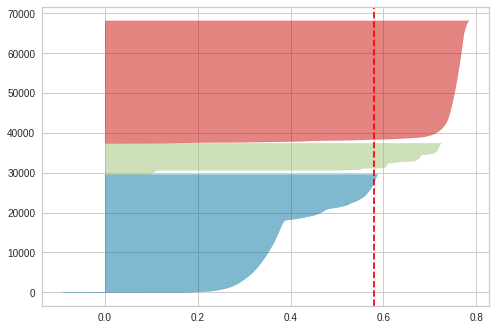

In [986]:
from yellowbrick.cluster import SilhouetteVisualizer

# Visualizamos el gráfico de silueta
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(ds_train_kmeans.drop(columns=["cluster"]))
plt.show()

Como se observa en el grafico, tenemos 3 grupos sin mediciones que esten mas cerca de otro cluster que del que pertenecen.


#### Analisis por grupo


In [987]:
#preparo dataset para analisis, necesito los valores sin normalizar para mejor interpretacion humana

#dummies
ds_grupos = pd.get_dummies(ds_train, columns=['property_type'])

#clusters
ds_grupos["cluster"] = ds_train_kmeans2["cluster"]

##### Grupo 0

In [988]:
ds_grupo0 = ds_grupos[ds_grupos["cluster"] == 0]

In [989]:
cantidad_de_obs = ds_grupo0.shape[0]
print("La cantidad de registros en este cluster es de: " + str(cantidad_de_obs))

La cantidad de registros en este cluster es de: 29656


Tipo y cantidad de observaciones de property_type

In [990]:
ds_grupo0[["property_type_Departamento", "property_type_Casa", "property_type_PH"]].sum()

property_type_Departamento    29656
property_type_Casa                0
property_type_PH                  0
dtype: int64

Algunos valores importantes

In [991]:
precio_promedio = ds_grupo0.property_price.mean().round()
print("El precio promedio de las propiedades es de: $" + str(precio_promedio) + " dolares")
sup_promedio = ds_grupo0.property_surface_total.mean().round()
print("El property_surface_total promedio de las propiedades es de: " + str(sup_promedio) + " metros cuadrados")
rooms_promedio = ds_grupo0.property_rooms.mean().round()
print("El property_rooms promedio de las propiedades es de: " + str(rooms_promedio) + " habitaciones")

El precio promedio de las propiedades es de: $259060.0 dolares
El property_surface_total promedio de las propiedades es de: 102.0 metros cuadrados
El property_rooms promedio de las propiedades es de: 4.0 habitaciones


Observar que este grupo solo posee propiedades del tipo departamento, esto es un buen indicio que los clusters se formaron en base del tipo de propiedad

##### Grupo 1

In [992]:
ds_grupo1 = ds_grupos[ds_grupos["cluster"] == 1]

In [993]:
cantidad_de_obs = ds_grupo1.shape[0]
print("La cantidad de registros en este cluster es de: " + str(cantidad_de_obs))

La cantidad de registros en este cluster es de: 7824


Tipo y cantidad de observaciones del tipo property_price

In [994]:
ds_grupo1[["property_type_Departamento", "property_type_Casa", "property_type_PH"]].sum()

property_type_Departamento       0
property_type_Casa            1053
property_type_PH              6771
dtype: int64

In [995]:
precio_prom = ds_grupo1[ds_grupo1["property_type_Casa"] == 1]["property_price"].mean().round()
sup_prom = ds_grupo1[ds_grupo1["property_type_Casa"] == 1]["property_surface_total"].mean().round()
rooms_prom = ds_grupo1[ds_grupo1["property_type_Casa"] == 1]["property_rooms"].mean().round()

print("El precio promedio de las propiedades Casa es de: $" + str(precio_prom) + " dolares")
print("Cantidad de habitaciones promedio de las propiedades Casa es: " + str(rooms_prom))
print("La superficie promedio de propiedades Casa es: " + str(sup_prom) + " metros cuadrados")

precio_prom = ds_grupo1[ds_grupo1["property_type_PH"] == 1]["property_price"].mean().round()
sup_prom = ds_grupo1[ds_grupo1["property_type_PH"] == 1]["property_surface_total"].mean().round()
rooms_prom = ds_grupo1[ds_grupo1["property_type_PH"] == 1]["property_rooms"].mean().round()

print("El precio promedio de las propiedades PH es de: $" + str(precio_prom) + " dolares")
print("Cantidad de habitaciones promedio de las propiedades PH es: " + str(rooms_prom) + " habitaciones")
print("La superficie promedio de propiedades PH es: " + str(sup_prom) + " metros cuadrados")

El precio promedio de las propiedades Casa es de: $284670.0 dolares
Cantidad de habitaciones promedio de las propiedades Casa es: 4.0
La superficie promedio de propiedades Casa es: 181.0 metros cuadrados
El precio promedio de las propiedades PH es de: $165041.0 dolares
Cantidad de habitaciones promedio de las propiedades PH es: 3.0 habitaciones
La superficie promedio de propiedades PH es: 109.0 metros cuadrados


Algunos valores importantes

In [996]:
precio_promedio = ds_grupo1.property_price.mean().round()
print("El precio promedio de las propiedades es de: $" + str(precio_promedio) + " dolares")
sup_promedio = ds_grupo1.property_surface_total.mean().round()
print("El property_surface_total promedio de las propiedades es de: " + str(sup_promedio) + " metros cuadrados")
rooms_promedio = ds_grupo1.property_rooms.mean().round()
print("El property_rooms promedio de las propiedades es de: " + str(rooms_promedio) + " habitaciones")

El precio promedio de las propiedades es de: $181142.0 dolares
El property_surface_total promedio de las propiedades es de: 118.0 metros cuadrados
El property_rooms promedio de las propiedades es de: 3.0 habitaciones


En este caso, la mayoria de los registros son del tipo PH, pero hay una cantidad de propiedades del tipo casa en este cluster.

##### Grupo 2

In [997]:
ds_grupo2 = ds_grupos[ds_grupos["cluster"] == 2]

In [998]:
cantidad_de_obs = ds_grupo2.shape[0]
print("La cantidad de registros en este cluster es de: " + str(cantidad_de_obs))

La cantidad de registros en este cluster es de: 30707


Tipo y cantidad de observaciones del tipo property_price

In [999]:
ds_grupo2[["property_type_Departamento", "property_type_Casa", "property_type_PH"]].sum()

property_type_Departamento    30707
property_type_Casa                0
property_type_PH                  0
dtype: int64

Algunos valores importantes

In [1000]:
precio_promedio = ds_grupo2.property_price.mean().round()
print("El precio promedio de las propiedades es de: $" + str(precio_promedio) + " dolares")
sup_promedio = ds_grupo2.property_surface_total.mean().round()
print("El property_surface_total promedio de las propiedades es de: " + str(sup_promedio) + " metros cuadrados")
rooms_promedio = ds_grupo2.property_rooms.mean().round()
print("El property_rooms promedio de las propiedades es de: " + str(rooms_promedio) + " habitaciones")

El precio promedio de las propiedades es de: $111069.0 dolares
El property_surface_total promedio de las propiedades es de: 48.0 metros cuadrados
El property_rooms promedio de las propiedades es de: 2.0 habitaciones


#### conclusiones

- Observando los cluster podemos observar que el tipo de propiedad tiene peso a la hora de decidir los clusters, tenemos dos clusters con solo proiedades del tipo departamento, y otro cluster con ambos, PH y Casa

Vemos que los clusters que poseen solo departamentos se diferencian en:

cluster 0:
- El precio promedio de las propiedades es de: $259060.0 dolares
- El property_surface_total promedio de las propiedades es de: 102.0 metros cuadrados
- El property_rooms promedio de las propiedades es de: 4.0 habitaciones


cluster 2:    
- El precio promedio de las propiedades es de: $111069.0 dolares
- El property_surface_total promedio de las propiedades es de: 48.0 metros cuadrados
- El property_rooms promedio de las propiedades es de: 2.0 habitaciones
                

- Si bien los clusters tienen propiedades iguales, hay una diferencia marcada en precio superficie y habitaciones, siendo los del cluster 0 "mejores" en esos aspectos.

#### Mapa


Delimitacionn de capital federal


In [1001]:
ds_mapa_point = geopandas.GeoDataFrame(ds_train_kmeans2, geometry=geopandas.points_from_xy(ds_train_kmeans2.longitud, ds_train_kmeans2.latitud))
ds_mapa_capital = geopandas.read_file("barrios_2/barrios-polygon.shp")

Text(0.5, 1.0, 'Mapa de propiedades en CABA')

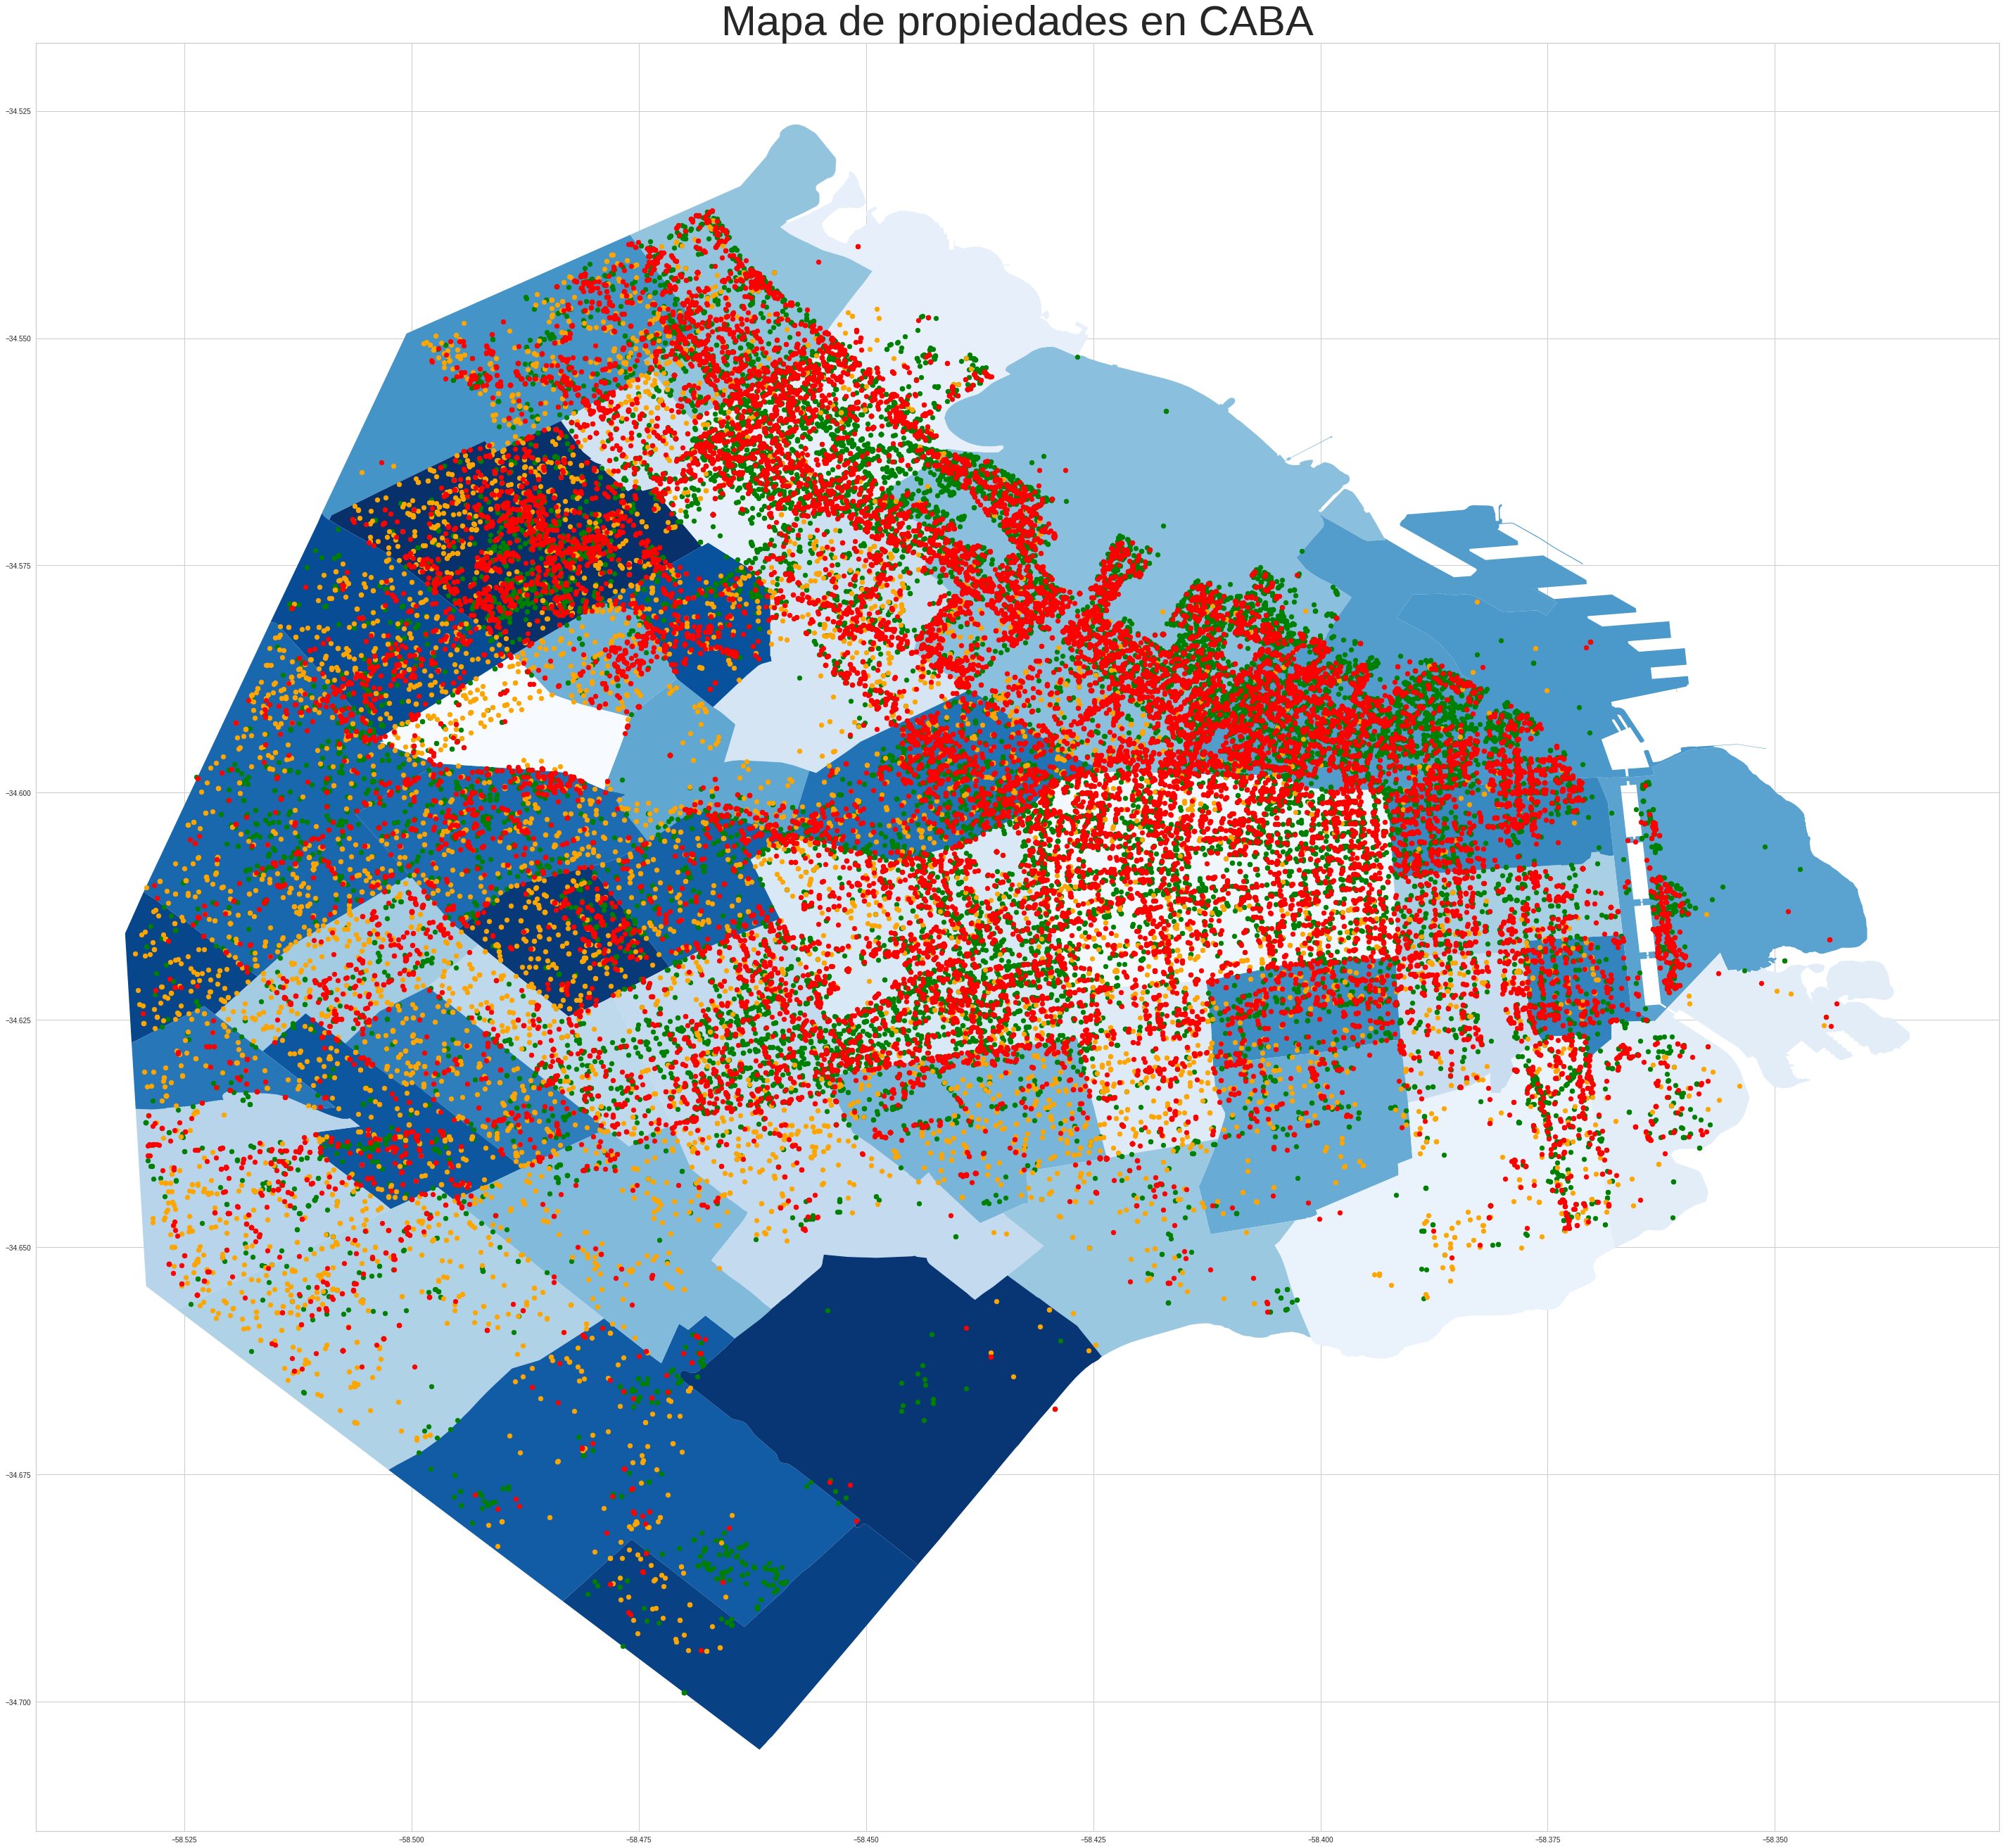

In [1002]:
fig,ax = plt.subplots(figsize = (50,50))
ds_mapa_capital.plot(ax = ax, column = "BARRIO", cmap = "Blues")
ds_mapa_point[ds_mapa_point["cluster"] == 0].plot(ax = ax, color = "green") # departamentos
ds_mapa_point[ds_mapa_point["cluster"] == 1].plot(ax = ax, color = "orange") #ph
ds_mapa_point[ds_mapa_point["cluster"] == 2].plot(ax = ax, color = "red") # casa
ax.set_title("Mapa de propiedades en CABA", fontdict = {"fontsize" : "60"})